# Lab 3: CRISP-DM Capstone
## Association Rule Mining, Clustering, or Collaborative Filtering

### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<a id="top"></a>
## Contents
* Business Understanding
* Data Understanding
    * <a href="#data1">Data Understanding 1</a>
    * <a href="#data2">Data Understanding 2</a>
* Modeling and Evaluation
    * <a href="#Model1">Train and Adjust Parameters</a>
    * <a href="#Model2">Evaluate and Compare</a>
    * <a href="#Model3">Visualize Results</a>
    * <a href="#Model4">Summarize the Ramifications</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>


In [1]:
# Display plots below cells
%matplotlib notebook

# Turn off annoying warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pprint
import pandas as pd
import numpy as np
import yellowbrick as yb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from pprint import pprint
from time import time
from datetime import datetime
from sklearn import metrics as mt
from sklearn import neighbors
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectPercentile, f_regression, mutual_info_regression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, mean_absolute_error, make_scorer, mean_squared_error, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer, scale
from sklearn.svm import LinearSVC, NuSVC, SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier, RidgeClassifier, LinearRegression
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, cross_validate, RandomizedSearchCV, cross_val_score
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ClassPredictionError, ROCAUC
from yellowbrick.features import Rank1D, Rank2D, RFECV
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

In [3]:
# Show all columns/rows in output
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

### Slack Integration

In [4]:
# Some setup is required before you can use this because token must be kept private
# I also need to add your name and unique identifier to the dictionary userID below
import os
from slackclient import SlackClient
from dotenv import load_dotenv

load_dotenv()

userID = {"brett": "UAN6UQEVC", "ryan": "UALUD69AB"}

#slackToken = os.environ["SLACK_BOT_TOKEN"]
#sc = SlackClient(slackToken)

def sendSlackMessage(msg, user):
    result = sc.api_call(
    "chat.postMessage",
    channel=userID[user.lower()],
    text=msg)
    
    if (not result['ok']):
        print("Error: {}".format(result))

ModuleNotFoundError: No module named 'slackclient'

### Supporting Functions

In [5]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    temp = scaler.fit(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# rmse, mape functions take from :https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [6]:
# code used to evaluate regression models used
# code from Dr. Drew github: https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [7]:
# Brett's directory
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"

dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets


In [8]:
# These names seem to cause problems so let's give them friendlier names
# renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
#               '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
#               '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
#               '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
#               '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
#               '_1_to_1_access_Yes': 'one_to_one_access_yes',
#               '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
#               '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
#               '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# # Rename columns
# dfPublicHS.rename(columns=renameCols, inplace = True)

In [9]:
# Replace all non alphanumeric characters with underscores
dfPublicHS.columns = dfPublicHS.columns.str.replace(r'\W', "_")

In [10]:
# Change all columns to floats since some libraries only work with floats
dfPublicHS = dfPublicHS.astype(float)

# Treat unit_code as a string
dfPublicHS["unit_code"] = dfPublicHS.astype({"unit_code": str})

In [11]:
#want to delete any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dfDropped = dfPublicHS

temp = dfDropped['ACT_Score']

dropCols = dfDropped.filter(regex = r'ACT')

dfDropped.drop(dropCols, axis = 1, inplace = True)

dfDropped['ACT_Score'] = temp

In [12]:
#list of all the columns that were deleted (note that ACT Score was put back into dataframe that is being used)
#dropCols.info()

In [13]:
dropColsPrin = dfDropped.filter(regex = r'prin')

dfDropped.drop(dropColsPrin, axis = 1, inplace = True)

#dropColsPrin.info()

#### Determine the 25% and 75% quartile. 

<IPython.core.display.Javascript object>


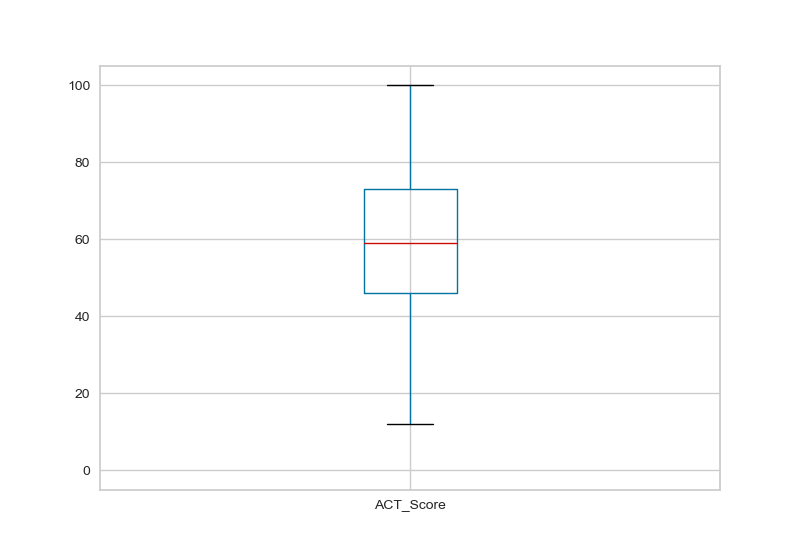

In [14]:
fig = plt.figure()
ax = fig.add_subplot()

dfDropped.boxplot(column=['ACT_Score'])
qSplit = dfDropped['ACT_Score'].quantile([.25, .50, .75, 1])

#### We want to explore the extremes

In [15]:
dfDropped["Q25"] = np.where(dfDropped['ACT_Score'] <= qSplit[.25], 1.0, 0.0)
dfDropped["Q50"] = np.where(dfDropped['ACT_Score'] <= qSplit[.50], 1.0, 0.0)
dfDropped["Q75"] = np.where(dfDropped['ACT_Score'] <= qSplit[.75], 1.0, 0.0)
dfDropped["Q100"] = np.where(dfDropped['ACT_Score'] <= qSplit[1], 1.0, 0.0)

<a href="#top">Back to Top</a> 
## Business Understanding (10 points total)

<span style="color: blue">Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?</span>


### Data Collection Overview
The team selected data from the Belk Endowment Educational Attainment Data for North Carolina Public Schools, which contains the North Carolina Public Schools Report Card as well as the Statistical Profiles Databases. This data was compiled by Dr. Jake Drew from original sources provided by the Public Schools of North Carolina (http://ncpublicschools.org), and the compilation, research, and analysis of the educational attainment data was funded by the John M. Belk Endowment (JMBE).

JMBE’s mission is focused on postsecondary education in North Carolina to help underrepresented students access and complete postsecondary education and be better prepared for entering the workforce. The educational attainment data set contains comprehensive statistics, demographics, and achievement metrics about North Carolina public, charter, and alternative elementary, middle, and high schools. This wealth of data is the foundation for research to help JMBE understand trends and improve postsecondary pathways in the state.

Our team has selected the 2017 high school data and utilized the machine learning data set prepared by Dr. Drew for analysis. Throughout the semester, we have been exploring the relationship between enrollment in postsecondary education within 16 months of high school graduation and teacher metrics related to teacher education, licensing, and certification, in addition to years of experience. This is important to help identify both positive and negative factors influencing students’ enrollment decisions and understand how educators can impact the pipeline to higher education.

Using the insights gained throughout the semester, our team has discovered that the ACT Score of a school strongly influences the percentage of students that enroll in post-secondary education [ANY RESULTS FROM PRIOR LABS TO QUANTIFY THIS!!??]. Now, we want to understand what factors are impacting ACT scores at the school level, which is the focus of the analysis in this lab. Our goals are to [WHAT!!??? – accurately classify schools into one of four ACT score quadrants…??]

### Algorithm Effectiveness
The team is using a two-pronged approach to mine the ACT data, starting with cluster analysis and then employing Random Forest for classification. Depending on the model, there are different metrics that can be used to analyze the effectiveness and predictive capability, and the most common metrics are outlined below. 

### *Clustering Algorithm*

#### Silhouette Analysis
Silhouette analysis is a method used to understand the validity and interpretation of clustering by balancing cohesion (how closely related objects are in a cluster) and separation (how distinct or well-separated a cluster is from other clusters). It measures the separation distance between resulting clusters, or how close each point in one cluster is to points in neighboring clusters. The metric, known as silhouette coefficients, range from -1 to 1. A coefficient of 0 indicates that the sample is either very close or completely aligned with the decision boundary between two neighboring clusters; a negative value indicates that samples may have been assigned to incorrect clusters. A positive value is ideal, with 1 being the optimal value. 

*Citations*:<br>
•	https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html<br>
•	https://en.wikipedia.org/wiki/Silhouette_(clustering)<br>
•	Tan, Pang-Ning, Steinbach, Michael, and Kumar, Vipin (2006), Introduction To Data Mining (1st ed.), Boston, MA: Person Education.

### *Classification Algorithms*

#### Confusion Matrix
The confusion matrix is a table that summarizes the performance of a classification model based on the count of test records that are correctly and incorrectly predicted by the model. This summary becomes the basis to calculate additional metrics such as accuracy, precision, recall, and the F-Score. 

| CONFUSION MATRIX 	| Predicted Yes  | Predicted No        	|
|------------------	|---------------------	|---------------------	|
| Actual Yes       	| True Positive (TP)  	| False Negative (FN) 	|
| Actual No        	| False Positive (FP) 	| True Negative (TN)  	|

#### Accuracy
Accuracy is a typical measurement used to evaluate classification models and is consider to be a good measure despite a few limitations. It is calculated by dividing the number of correct predictions by the total number of predictions, or TP + TN / TP + TN + FP + FN. The error rate is essentially the opposite of accuracy and looks at incorrect predictions. Most classification algorithms seek models that attain the highest accuracy, or equivalently, the lowest error rate when applied to the test set. 

One obvious limitation of accuracy is that it ignores the cost of misclassification, and this is particularly evident when the algorithm is trying to predict on imbalanced data sets. This can be addressed by looking at other metrics as part of the evaluation process.

#### Precision
Precision is a widely used classification metric where the successful detection of one class is more important than another. It is a cost-sensitive measure for the fraction of actual positive records in the group that the classifier declared in the positive class. The calculation for precision is TP / TP + FP. Higher precision means lower false positives, and the metric tends to be biased toward true positives. A good model will maximize precision.

#### Recall
Similar to precision, recall is also a widely used cost-sensitive classification metric. It measures the fraction of positive examples correctly predicted by the model, where large recall measures have few positive examples misclassified as negative, or lower false negatives. The calculation is TP / TP + FN, and the measure penalizes the model when it yields a negative when the true result is positive. Again, a good model will maximize recall. 

#### F-Score
Precision and recall can be summarized into the F-score metric (also known as the F-1 measure or F-measure). Generally, this score is a weighted accuracy measure that takes into account both precision and recall. It is calculated as the harmonic mean between the two: 2 x TP / 2 x TP + FP + FN. This too is a metric to maximize; a high value F-score indicates that precision and recall are reasonably high.  

*Citation*:<br>
•	Tan, Pang-Ning, Steinbach, Michael, and Kumar, Vipin (2006), Introduction To Data Mining (1st ed.), Boston, MA: Person Education.

### Cross Validation
Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

NW QUESTIONS:
 - How did we use cross validation? What was our methodology and reasoning? K-fold CV, Stratified K-fold CV, another method?

*Citation*:<br>
•	https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f


<a href="#top">Back to Top</a> 
## Data Understanding (20 points total)
<a id="data1"></a>
### Data Understanding 1 (10 points)

<span style="color: blue">Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?</span>

<a href="#top">Back to Top</a> 
<a id="data2"></a>
### Data Understanding 2 (10 points)

<span style="color: blue">Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

<span style="color: blue">Note: "Visualize the any" is verbatim from syllabus</span>


In [16]:
zeroScore = dfDropped[dfDropped['ACT_Score'] == 0]
zeroScore[['student_num', 'ACT_Score']]

student_num  ACT_Score
8           56.0        0.0
16          64.0        0.0
51          62.0        0.0
78           8.0        0.0
187        443.0        0.0
311         68.0        0.0
332         46.0        0.0
340        149.0        0.0
353        502.0        0.0
463         59.0        0.0
465        347.0        0.0

School 8 is Alexander Early College (https://www.alexander.k12.nc.us/aec). This would explain why its class size (56) is less than 10% of the average school size in the district (Alexander County Schools, 727). They also advertise that their 4-5 year program simultaneously earns its students a high school diploma along with up to two years of college credits or an Associate's Degree in Art or Science. This would explain why their small student class does not take an ACT exam.

School 16 is Avery High Viking Academy out of the Avery County Schools district. It also has a small class size (64) compared to its district's average of 195. This school does not have a listed url so additional background information for context cannot be obtained.

School 51 is the Cabarrus Early College of Technology. Like the other schools listed it has a very small class size (62) compared to the average school size in the district (Cabarrus County Schools, 1106). A URL was not provided with the data set but a google search yielded https://www.cabarrus.k12.nc.us/Domain/8438. Like with Alexander Early College, Cabarrus Early College of Techonlogy offers a similar program that students will simultaneously earn a high school diploma with an Associate's Degree with a focus on STEM (science, technology, engineering, and mathematics). Again, this would explain why the students do not take the ACT, because they have already obtained college credits that it is not needed.

School 78 is the Chatham School of Science & Engineering (https://www.chatham.k12.nc.us/Domain/1813) inside of the Chatham County Schools. It also provides its students the opportunity to obtain an Associate's Degree along side their High School Diploma.

School 187 is Doris Henderson Newcomers SChool (https://www.gcsnc.com/domain/757) inside of the Guilford County Schools. This school actually has a much larger class size (443) than its district's average (193). It is a school for grades 3-12 for immigrant and refugee students.

School 311 is Northampton Early College (https://northamptonec.sharpschool.com/) in the Northampton County Schools district. It looks to be another Associate's Degree program within the high school curriculum.

School 332 is Person Early College Innovation & Leadership in the Person County Schools. It also is a five year program that allows students to obtain an Associate's Degree alongside their High School Diploma.

School 340 is Early College High School (https://www.pitt.k12.nc.us/domain/890) in the Pitt County Schools district. It also allows students to obtain a Associate's Degree along with their High School Diploma.

School 353 is Richmond County 9th Grade Academy (http://www.richmond.k12.nc.us/RCNGA/) in the Richmond County Schools district. 

School 463 is Wilson Academy of Applied Technology (https://waat.wilsonschoolsnc.net/) in the Wilson County Schools district. It is also a combined High School Diploma and Associate's Degree program.

School 465 is Boonville Elementary in the Yadkin County Schools district. It is not a high school and will be deleted.

<IPython.core.display.Javascript object>


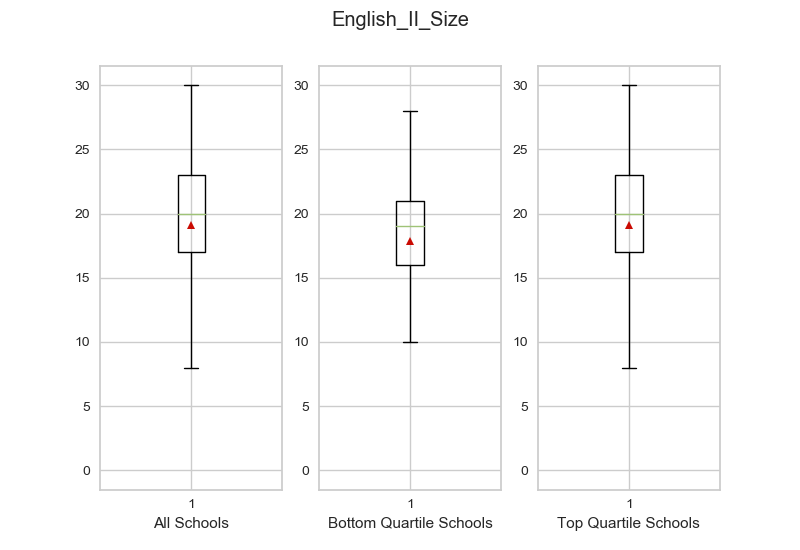

<IPython.core.display.Javascript object>


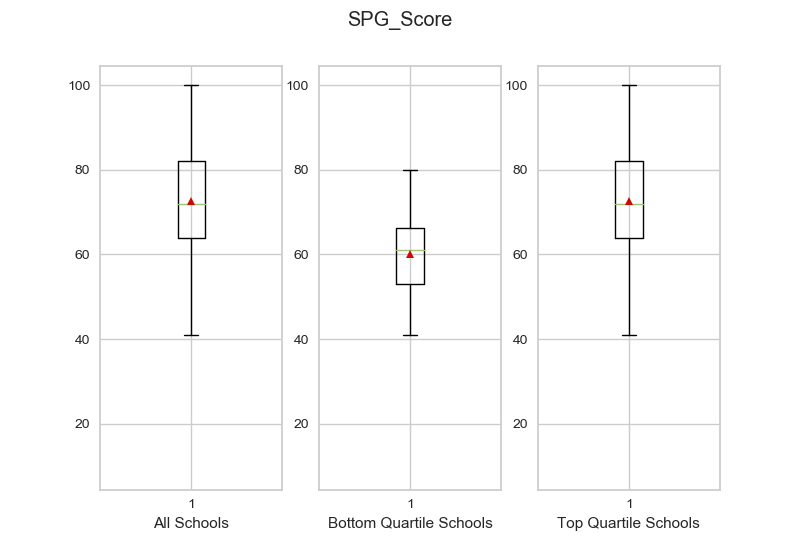

<IPython.core.display.Javascript object>


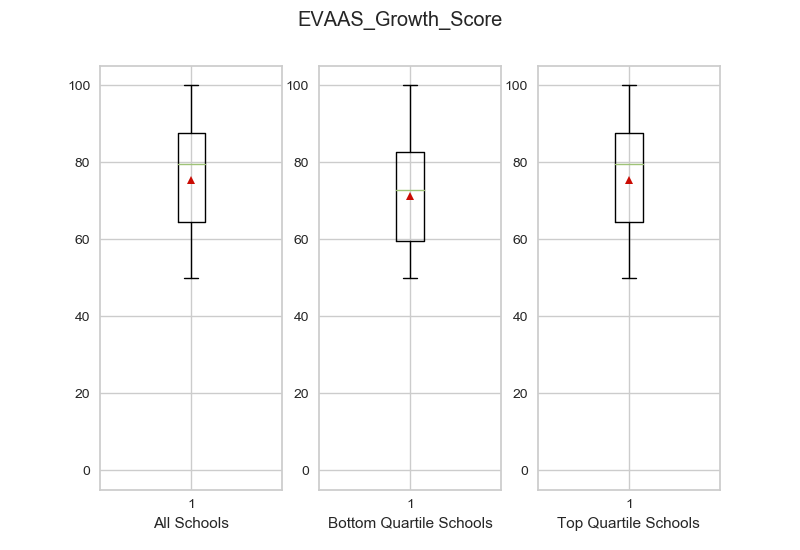

<IPython.core.display.Javascript object>


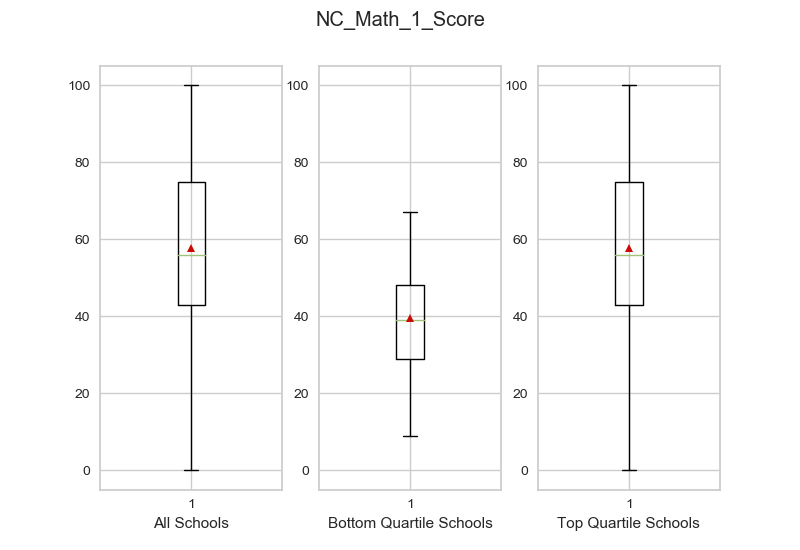

<IPython.core.display.Javascript object>


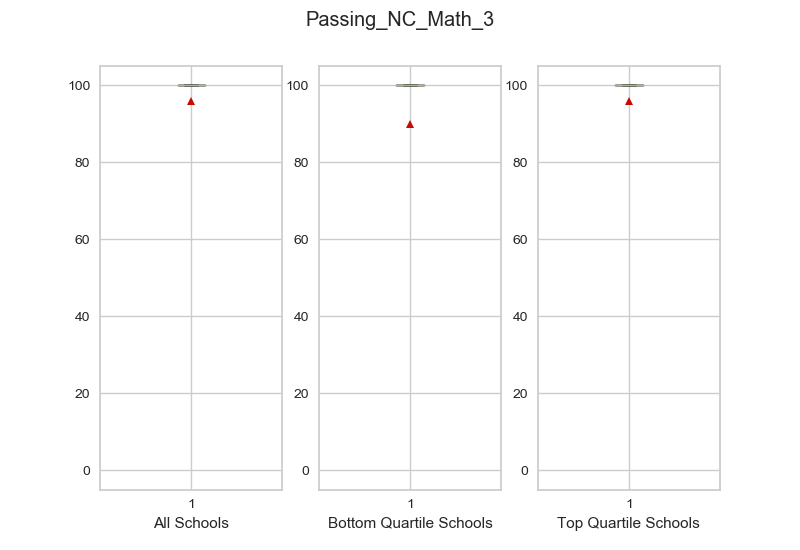

<IPython.core.display.Javascript object>


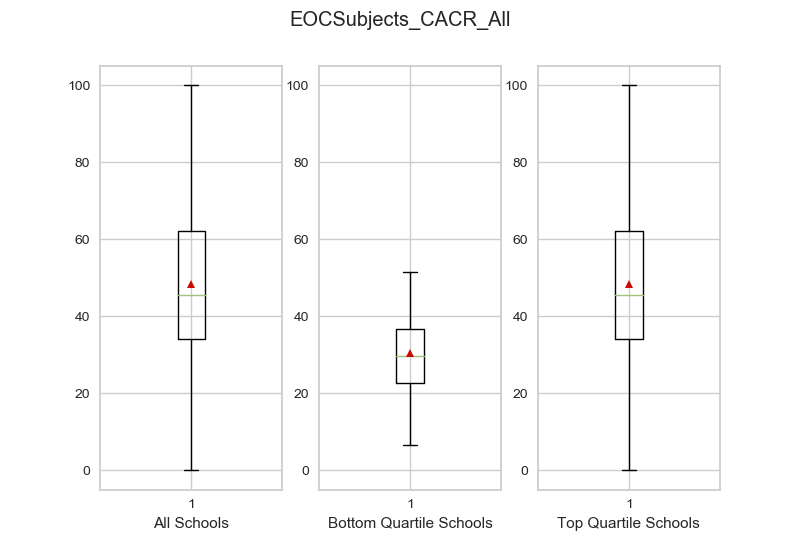

<IPython.core.display.Javascript object>


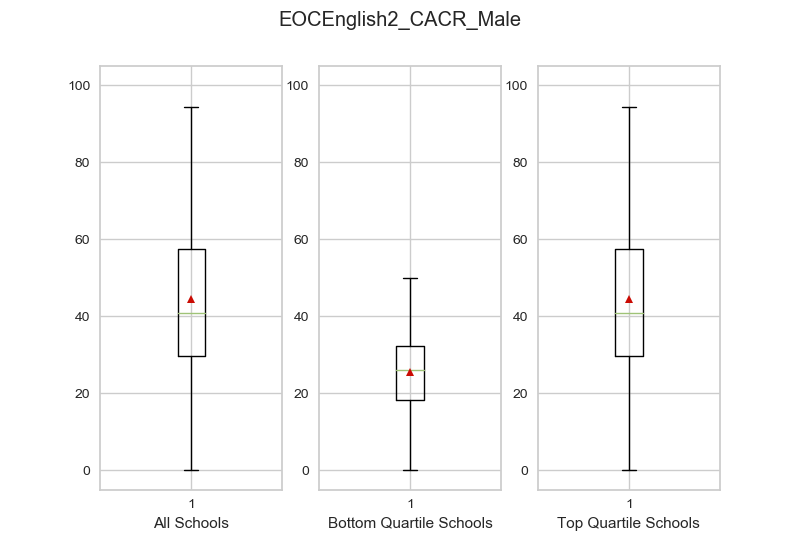

<IPython.core.display.Javascript object>


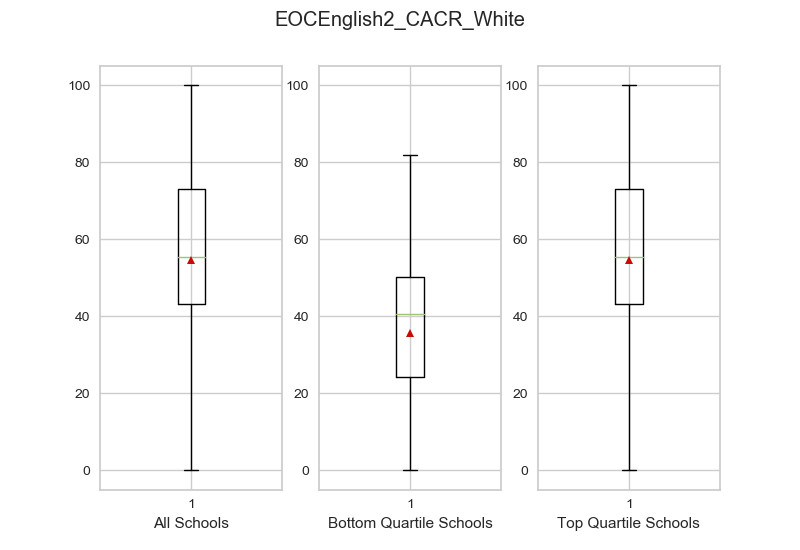

<IPython.core.display.Javascript object>


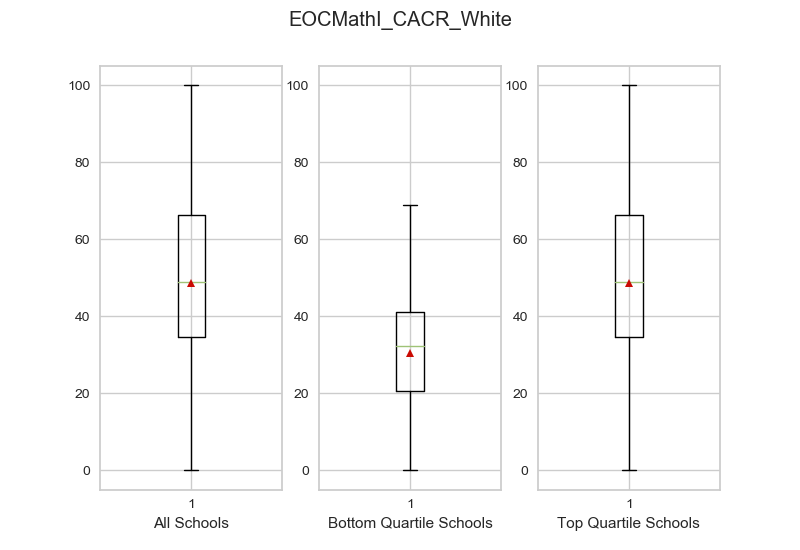

<IPython.core.display.Javascript object>


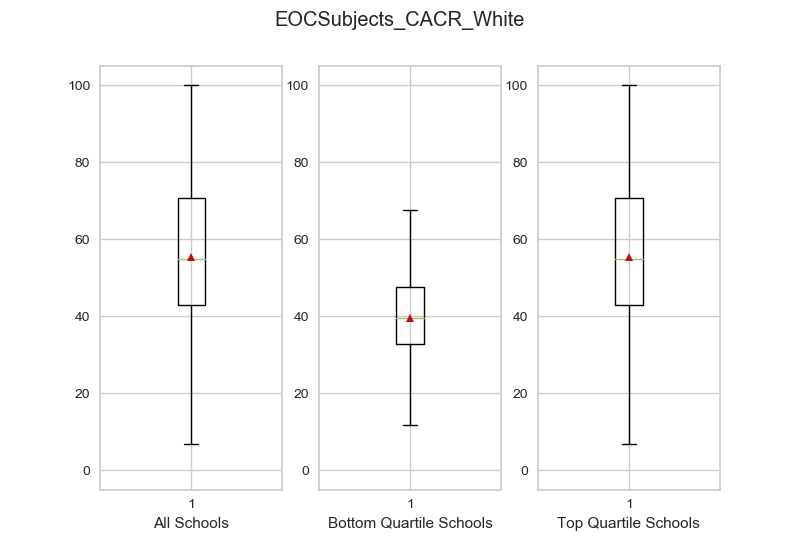

<IPython.core.display.Javascript object>


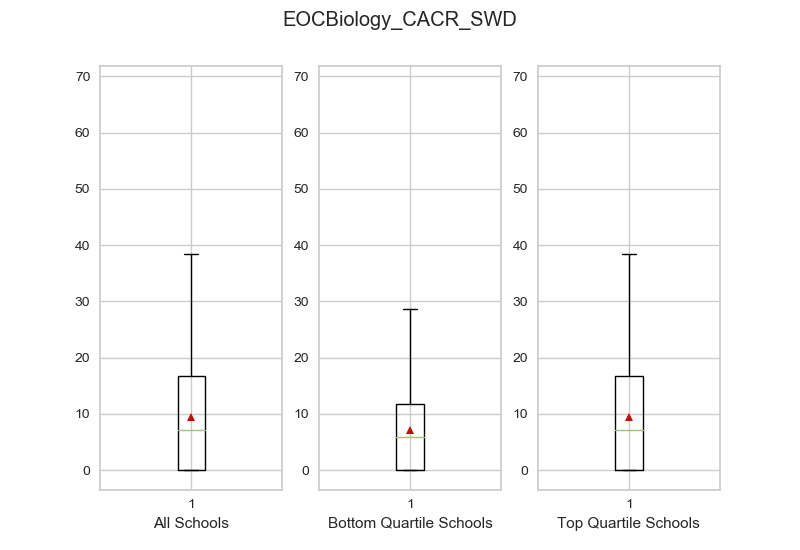

<IPython.core.display.Javascript object>


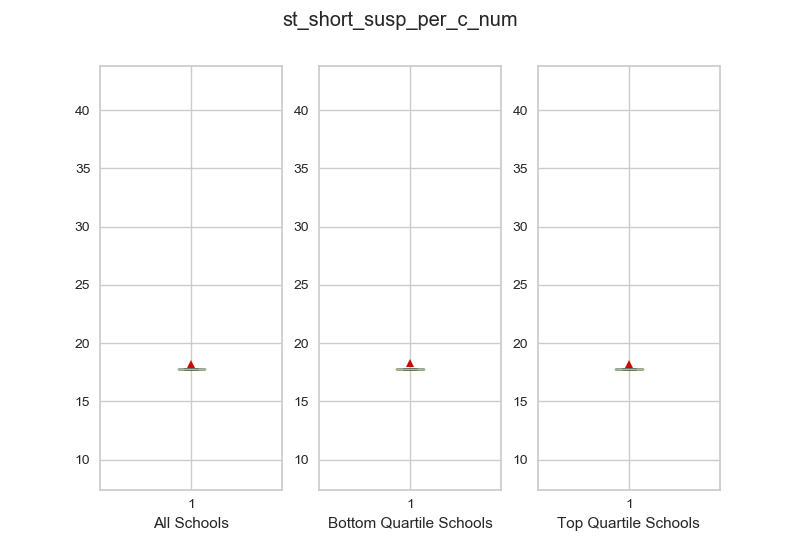

<IPython.core.display.Javascript object>


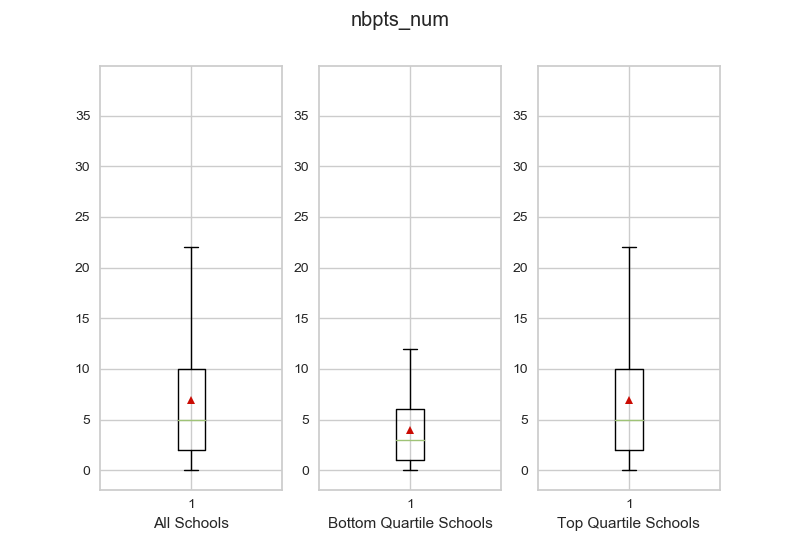

<IPython.core.display.Javascript object>


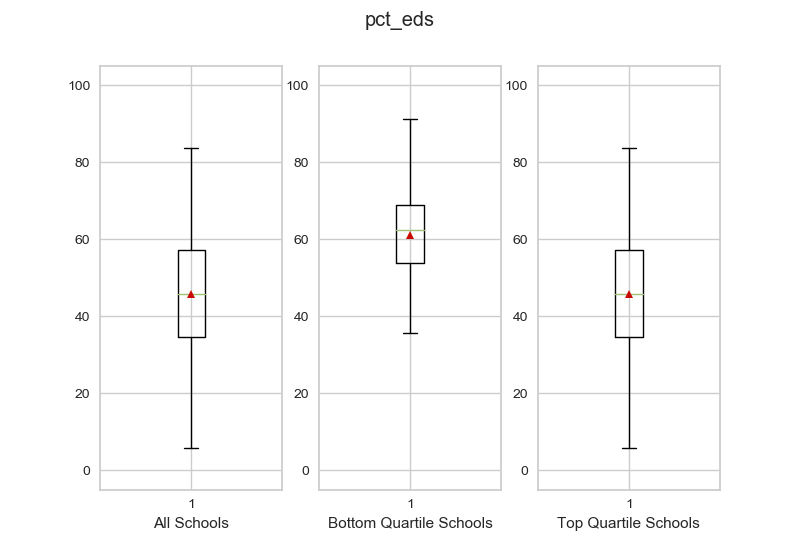

In [17]:
featCols = ['English_II_Size', 'SPG_Score', 'EVAAS_Growth_Score', 'NC_Math_1_Score', 
            'Passing_NC_Math_3', 'EOCSubjects_CACR_All', 'EOCEnglish2_CACR_Male',
            'EOCEnglish2_CACR_White', 'EOCMathI_CACR_White', 'EOCSubjects_CACR_White',
            'EOCBiology_CACR_SWD', 'st_short_susp_per_c_num', 'nbpts_num', 'pct_eds']

for feat in featCols:
    fig = plt.figure()
    fig.suptitle(feat)

    ax = fig.add_subplot(131)
    plt.boxplot(dfDropped[feat], showmeans=True)
    ax.set_xlabel('All Schools')

    ax = fig.add_subplot(132, sharey=ax)
    btmQ = dfDropped[dfDropped['Q25'] == 1]
    plt.boxplot(btmQ[feat], showmeans=True)
    ax.set_xlabel('Bottom Quartile Schools')

    ax = fig.add_subplot(133, sharey=ax)
    topQ = dfDropped[dfDropped['Q100'] == 1]
    plt.boxplot(topQ[feat], showmeans=True)
    ax.set_xlabel('Top Quartile Schools')
    
# del dfDropped['Q100']

In [18]:
breaks = np.asarray(np.percentile(dfDropped['ACT_Score'], [25,50,75,100]))
dfDropped['ACT_Score_Quartiles'] = (dfDropped['ACT_Score'].values > breaks[..., np.newaxis]).sum(0)

<IPython.core.display.Javascript object>


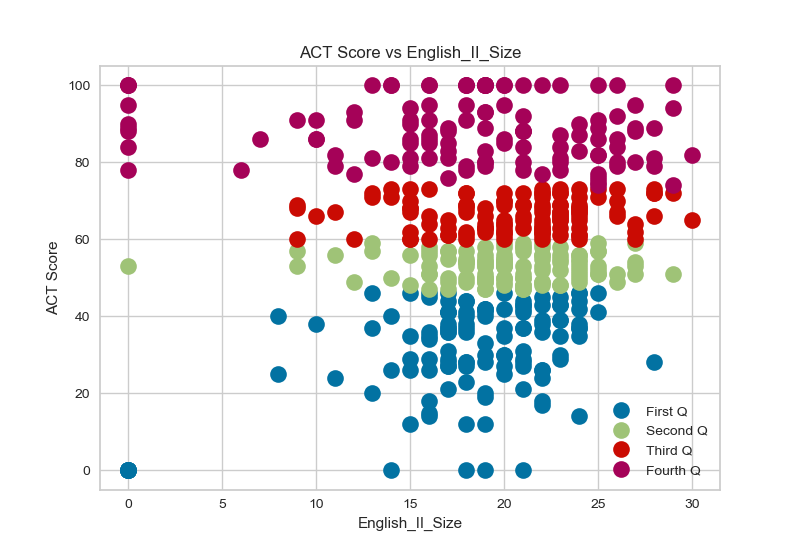

<IPython.core.display.Javascript object>


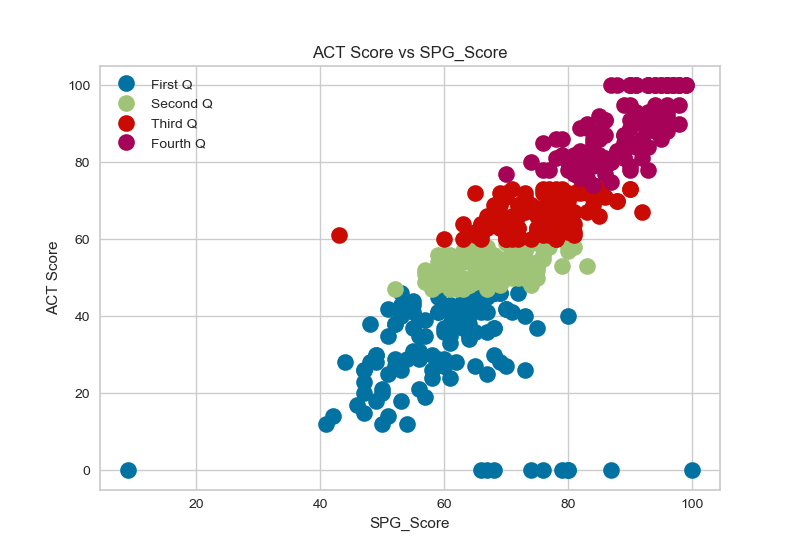

<IPython.core.display.Javascript object>


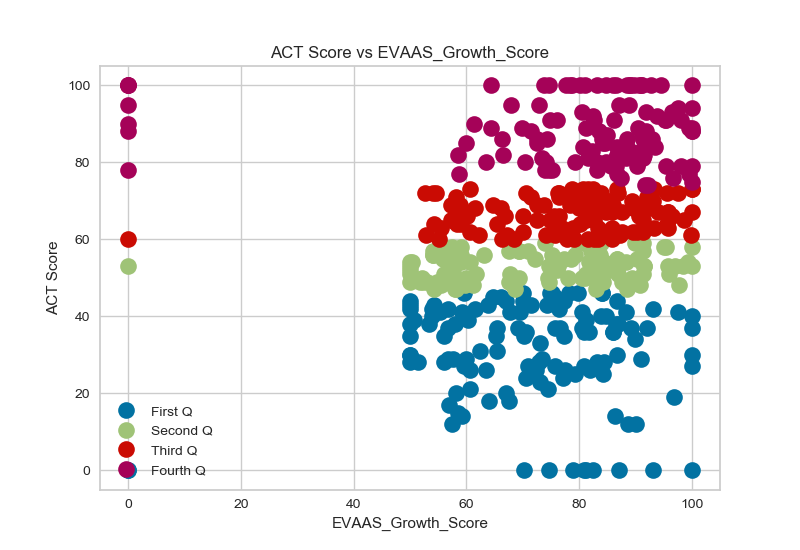

<IPython.core.display.Javascript object>


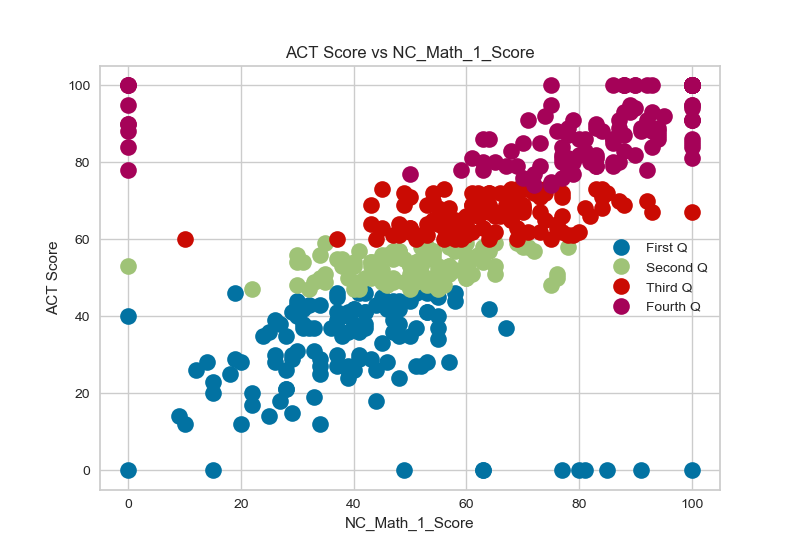

<IPython.core.display.Javascript object>


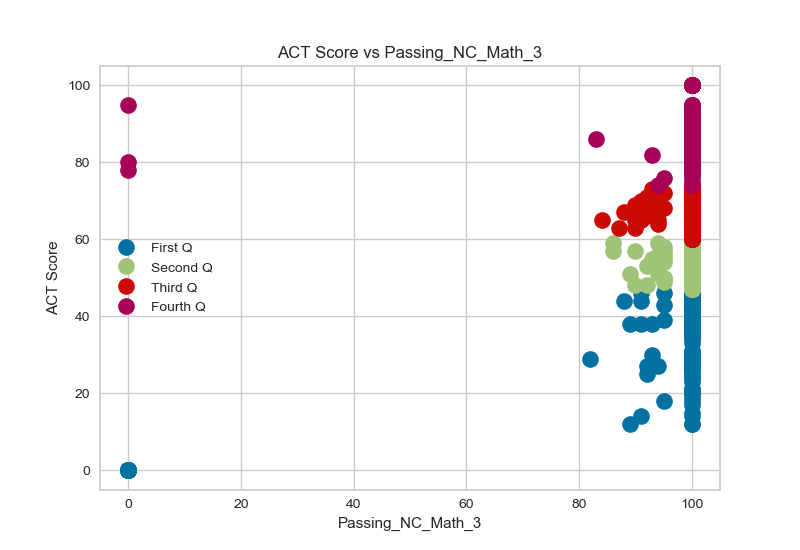

<IPython.core.display.Javascript object>


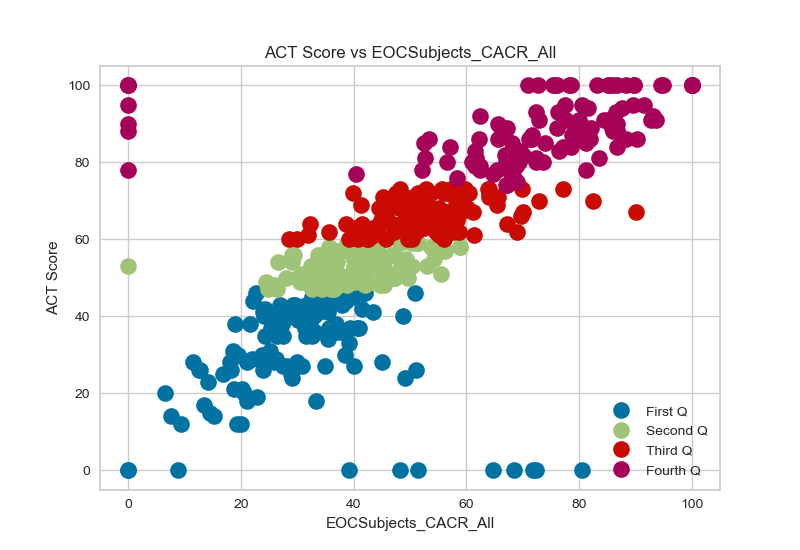

<IPython.core.display.Javascript object>


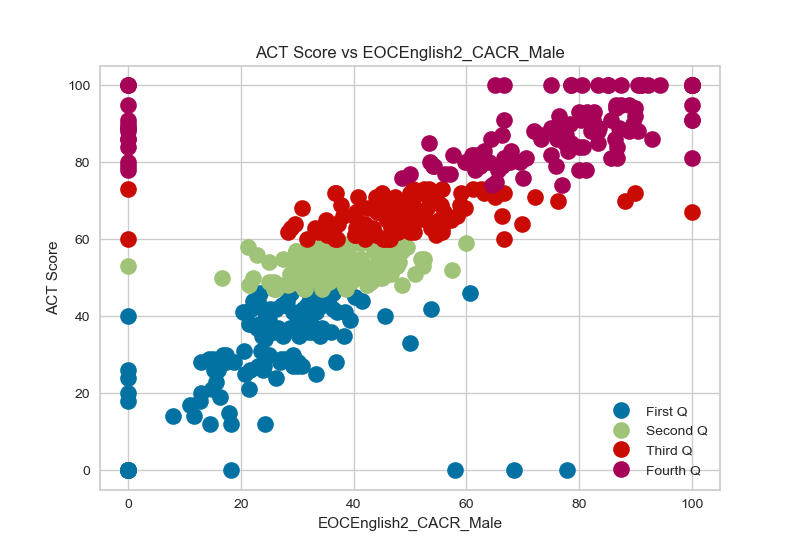

<IPython.core.display.Javascript object>


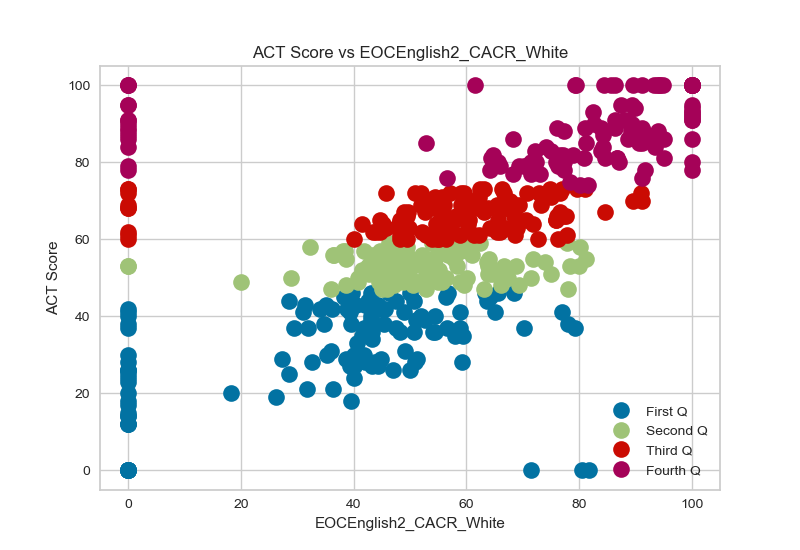

<IPython.core.display.Javascript object>


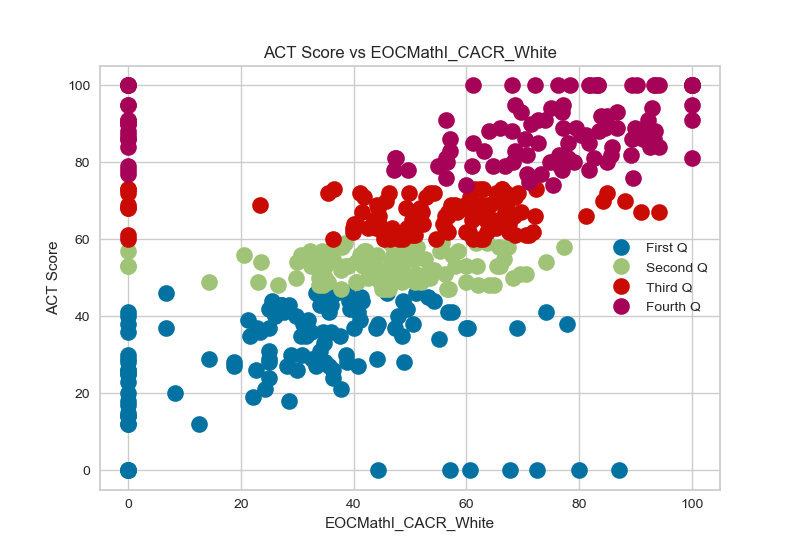

<IPython.core.display.Javascript object>


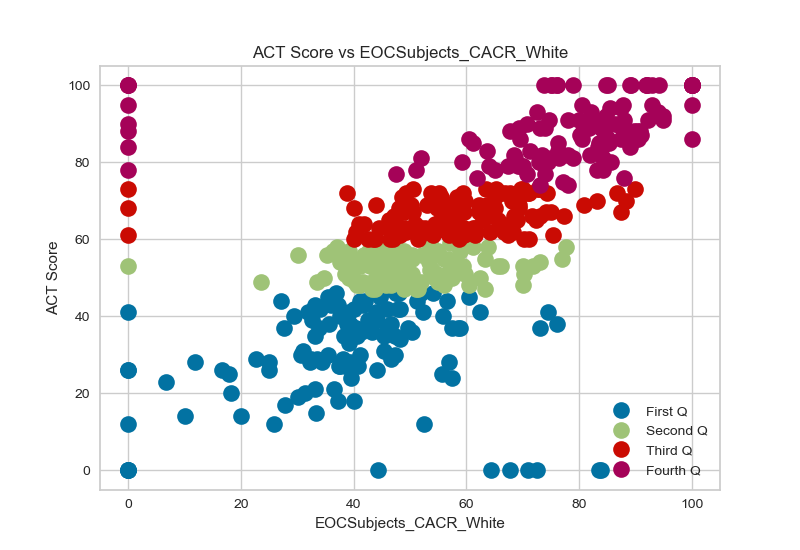

<IPython.core.display.Javascript object>


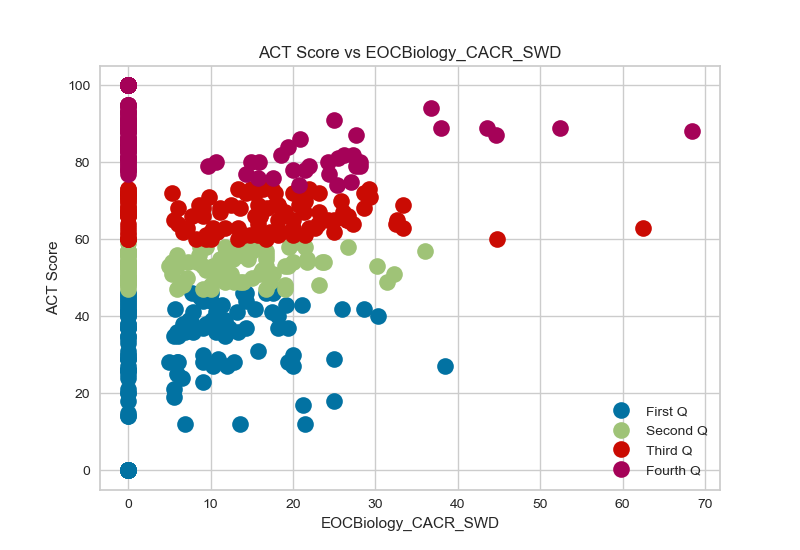

<IPython.core.display.Javascript object>


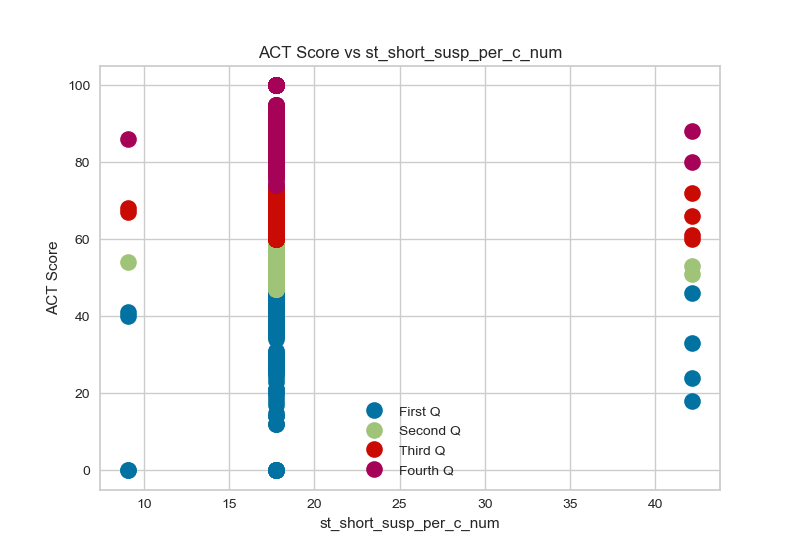

<IPython.core.display.Javascript object>


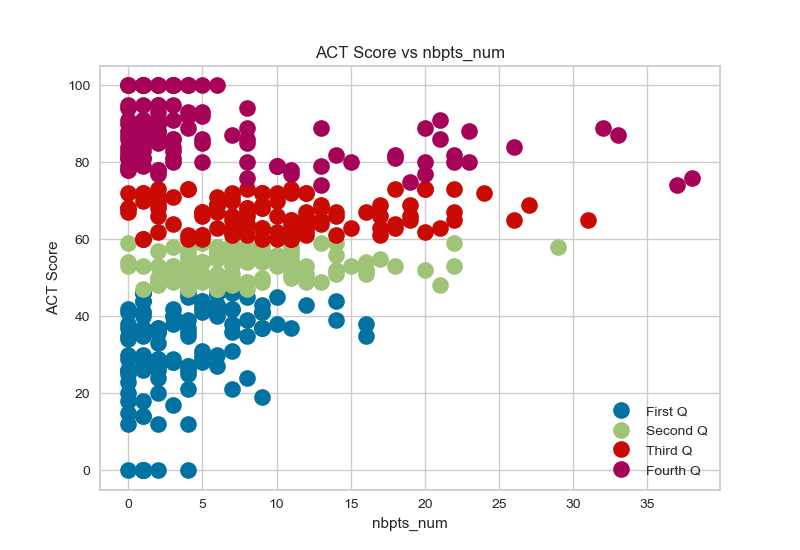

<IPython.core.display.Javascript object>


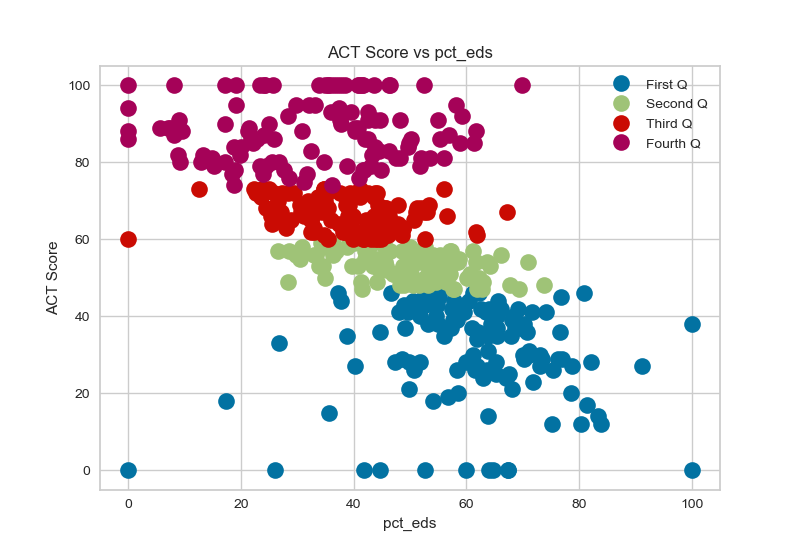

In [19]:
quartile = {0: "First Q", 1: "Second Q", 2: "Third Q", 3: "Fourth Q"}

# scatter plot code from: https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
groups = dfDropped.groupby('ACT_Score_Quartiles')

for feat in featCols:
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(getattr(group, feat), group.ACT_Score, marker='o', 
                    linestyle='', ms=12, label=quartile[name])
    ax.legend()
    ax.set(title='ACT Score vs ' + feat, 
               xlabel=feat,
               ylabel='ACT Score')

    plt.show()

<a href="#top">Back to Top</a> 
## Modeling and Evaluation (50 points total)

<span style="color: blue">Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. Each option is broken down by: 

<ul style = "color: blue">
<li>Train and Adjust Parameters</li>
<li>Evaluate and Compare</li>
<li>Visualize Results</li>
<li>Summarize the Ramifications</li>


<ul style="color: blue">
<li><strong>Option A: Cluster Analysis</strong></li>
    <ul style="color: blue">
    <li><strong>Train</strong>: Perform cluster analysis using several clustering methods (adjust parameters).</li>
    <li><strong>Eval</strong>: Use internal and/or external validation measures to describe and compare the clusterings and the clusters — how did you determine a suitable number of clusters for each method?</li>
    <li><strong>Visualize</strong>: Use tables/visualization to discuss the found results. Explain each visualization in detail.</li>
    <li><strong>Summarize</strong>: Describe your results. What findings are the most interesting and why?</li>
    </ul></ul>

<ul style="color: blue">
<li><strong>Option B: Association Rule Mining</strong></li>
    <ul style="color: blue">
    <li><strong>Train</strong>: Create frequent itemsets and association rules (adjust parameters).</li>
    <li><strong>Eval</strong>: Use several measure for evaluating how interesting different rules are.</li>
    <li><strong>Visualize</strong>: Use tables/visualization to discuss the found results.</li>
<li><strong>Summarize</strong>: Describe your results. What findings are the most interesting and why?</li>
    </ul></ul>

<ul style = "color: blue">
<li><strong>Option C: Collaborative Filtering</strong></li>
    <ul style="color: blue">
    <li><strong>Train</strong>: Create user-item matrices or item-item matrices using collaborative filtering (adjust parameters).</li>
    <li><strong>Eval</strong>: Determine performance of the recommendations using different performance measures (explain the ramifications of each measure).</li>
    <li><strong>Visualize</strong>: Use tables/visualization to discuss the found results. Explain each visualization in detail.</li>
    <li><strong>Summarize</strong>: Describe your results. What findings are the most interesting and why?</li>

| Method name                  | Parameters                                 | Scalability                                                 | Best Use Case                                                                   | Geometry/Measurement Metric                       |
|------------------------------|--------------------------------------------|-------------------------------------------------------------|---------------------------------------------------------------------------|----------------------------------------------|
| K-Means                      | number of clusters                         | Very large n_samples, medium n_clusters with MiniBatch code | General-purpose, even cluster size, flat geometry, not too many clusters  | Distances between points                     |
| DBSCAN                       | neighborhood size                          | Very large n_samples, medium n_clusters                     | Non-flat geometry, uneven cluster sizes                                   | Distances between nearest points             |
| Agglomerative clustering     | number of clusters, linkage type, distance | Large n_samples and n_clusters                              | Many clusters, possibly connectivity constraints, non Euclidean distances | Any pairwise distance                        |
| Ward hierarchical clustering | number of clusters                         | Large n_samples and n_clusters                              | Many clusters, possibly connectivity constraints                          | Distances between points                     |
| Spectral clustering          | number of clusters                         | Medium n_samples, small n_clusters                          | Few clusters, even cluster size, non-flat geometry                        | Graph distance (e.g. nearest-neighbor graph) |
| Gaussian mixtures            | many                                       | Not scalable                                                | Flat geometry, good for density estimation                                | Mahalanobis distances to centers             |

### Clustering on Feature Columns

| METHOD             | Number of Clusters | Silhouette Score | Notes/Explanation |
|--------------------|--------------------|------------------|-------------------|
| K-Means            | 2                  | 0.3506           | blah blah blah    |
| K-Means            | 6                  | 0.6947           | blah blah blah    |
| Mini-Batch K-Means | 2                  | 0.3505           | blah blah blah    |
| Mini-Batch K-Means | 4                  | 0.6851           | blah blah blah    |
| DBSCAN             | 10                 | 0.2293           | blah blah blah    |
| DBSCAN             | 12                 | 0.6596           | blah blah blah    |
| Agglomerative      | 2                  | 0.5050           | blah blah blah    |
| Agglomerative      | 5                  | 0.6628           | blah blah blah    |


### Clustering on Top and Bottom Quartiles of Schools, based on ACT Scores

| METHOD             | Number of Clusters | Silhouette Score | Notes/Explanation |
|--------------------|--------------------|------------------|-------------------|
| K-Means            | 2                  | 0.4734           | blah blah blab    |
| K-Means            | 7                  | 0.9755           | blah blah blab    |
| Mini-Batch K-Means | 2                  | 0.4733           | blah blah blab    |
| Mini-Batch K-Means | 4                  | 0.9714           | blah blah blab    |
| DBSCAN             | 17                 | 0.0539           | blah blah blab    |
| DBSCAN             | 15                 | 0.9776           | blah blah blab    |
| Agglomerative      | 9                  | 0.4714           | blah blah blab    |
| Agglomerative      | 4                  | 0.9816           | blah blah blab    |

In [20]:
# create cross validation variable
cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

# training data
X = dfDropped[featCols]

# target variable
y = dfDropped['ACT_Score_Quartiles']

# Classifier
cls = RandomForestClassifier(random_state = 42)

# Results Dictionary
bestResults = {}

In [21]:
def scoreRF(X, y, cLabels):
    acc = cross_val_score(cls, X, y = y, cv = cv, scoring = 'accuracy', n_jobs=-1)
    if len(np.unique(cLabels)) > 1:
        sil = silhouette_score(dfDropped[featCols], cLabels)
    else:
        sil = -2
    result = {'mean': acc.mean(), 'std': acc.std(), 'sil': sil}
    
    return result

In [22]:
def scoreExtremeRF(X, y, cLabels):
    acc = cross_val_score(cls, X, y = y, cv = cv, scoring = 'accuracy', n_jobs=-1)
    if len(np.unique(cLabels)) > 1:
        sil = silhouette_score(dfExtremes[featCols], cLabels)
    else:
        sil = -2
    result = {'mean': acc.mean(), 'std': acc.std(), 'sil': sil}
    
    return result

In [23]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    # Instantiate the clustering model
    model = KMeans(n_clusters = kSize, random_state = 42)
    model.fit(X)
    cLabels = model.labels_
    
    X = np.column_stack((X, pd.get_dummies(cLabels)))
    result = scoreRF(X, y, cLabels)
      
    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFkSize = kSize
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilkSize = kSize
        bestSilLabels = cLabels
        
bestResults['kmeans'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Result: {}".format(bestRFkSize, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Silhouette Score: 0.35059113968556144
Best Accuracy Score: 
	 K Size: 6 
	 Result: 0.6946808510638298


In [24]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    # Instantiate the clustering model
    model = MiniBatchKMeans(n_clusters = kSize, random_state = 42)
    model.fit(X)
    cLabels = model.labels_
    
    X = np.column_stack((X, pd.get_dummies(cLabels)))
    result = scoreRF(X, y, cLabels)

    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFkSize = kSize
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilkSize = kSize
        bestSilLabels = cLabels
        
bestResults['batchkmeans'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Accuracy: {}".format(bestRFkSize, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Silhouette Score: 0.35049077519737154
Best Accuracy Score: 
	 K Size: 4 
	 Accuracy: 0.6851063829787234


In [25]:
bestAcc = 0
bestSil = -2

for minS in np.arange(10, 20):
    for eps in np.arange(15, 25):
        # Instantiate the clustering model
        model = DBSCAN(eps = eps, min_samples=minS, n_jobs=-1)
        model.fit(X)
        cLabels = model.labels_

        X = np.column_stack((X, pd.get_dummies(cLabels)))
        result = scoreRF(X, y, cLabels)

        #print("Eps: {} \t Min Samples: {} \t Result: {}".format(eps, minS, result['mean']))
        
    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFMinS = minS
        bestRFEps = eps
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilMinS = minS
        bestSilEps = eps
        bestSilLabels = cLabels
        
bestResults['dbscan'] = bestAcc

print("Best Silhouette Score: \n\t Min Samples: {} \n\t Eps: {} \n\t Silhouette Score: {}".format(bestSilMinS, bestSilEps, bestSil))
print("Best Accuracy Score: \n\t Min Samples: {} \n\t Eps: {} \n\t Accuracy: {}".format(bestRFMinS, bestRFEps, bestAcc))

Best Silhouette Score: 
	 Min Samples: 10 
	 Eps: 24 
	 Silhouette Score: 0.2293456525693385
Best Accuracy Score: 
	 Min Samples: 12 
	 Eps: 24 
	 Accuracy: 0.6595744680851064


In [26]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    for link in ['ward', 'complete', 'average']:
        # Instantiate the clustering model
        model = AgglomerativeClustering(n_clusters = kSize, linkage = link)
        model.fit(X)
        cLabels = model.labels_

        X = np.column_stack((X, pd.get_dummies(cLabels)))
        result = scoreRF(X, y, cLabels)

        #print("Eps: {} \t Min Samples: {} \t Result: {}".format(eps, minS, result['mean']))
        
        if result['mean'] > bestAcc:
            bestAcc = result['mean']
            bestRFkSize = kSize
            bestRFLink = link
            bestRFLabels = cLabels
        
        if result['sil'] > bestSil:
            bestSil = result['sil']
            bestSilkSize = kSize
            bestSilLink = link
            bestSilLabels = cLabels
        
bestResults['agg'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Link: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSilLink, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Link: {} \n\t Accuracy: {}".format(bestRFkSize, bestRFLink, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Link: average 
	 Silhouette Score: 0.5050109218076708
Best Accuracy Score: 
	 K Size: 5 
	 Link: average 
	 Accuracy: 0.6627659574468084


In [27]:
dfExtremes = dfDropped[(dfDropped['ACT_Score_Quartiles'] == 0) | (dfDropped['ACT_Score_Quartiles'] == 3)]

X = dfExtremes[featCols]

y = dfExtremes['ACT_Score_Quartiles']

In [28]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    # Instantiate the clustering model
    model = KMeans(n_clusters = kSize, random_state = 42)
    model.fit(X)
    cLabels = model.labels_
    
    X = np.column_stack((X, pd.get_dummies(cLabels)))
    result = scoreExtremeRF(X, y, cLabels)
      
    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFkSize = kSize
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilkSize = kSize
        bestSilLabels = cLabels
        
bestResults['extreme_kmeans'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Result: {}".format(bestRFkSize, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Silhouette Score: 0.4733754315377237
Best Accuracy Score: 
	 K Size: 7 
	 Result: 0.9755102040816326


In [49]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    # Instantiate the clustering model
    model = MiniBatchKMeans(n_clusters = kSize, random_state = 42)
    model.fit(X)
    cLabels = model.labels_
    
    X = np.column_stack((X, pd.get_dummies(cLabels)))
    result = scoreExtremeRF(X, y, cLabels)

    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFkSize = kSize
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilkSize = kSize
        bestSilLabels = cLabels
        
bestResults['extreme_batchkmeans'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Accuracy: {}".format(bestRFkSize, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Silhouette Score: 0.4733754315377237
Best Accuracy Score: 
	 K Size: 4 
	 Accuracy: 0.9714285714285713


In [30]:
bestAcc = 0
bestSil = -2

for minS in np.arange(10, 20):
    for eps in np.arange(15, 25):
        # Instantiate the clustering model
        model = DBSCAN(eps = eps, min_samples=minS, n_jobs=-1)
        model.fit(X)
        cLabels = model.labels_

        X = np.column_stack((X, pd.get_dummies(cLabels)))
        result = scoreExtremeRF(X, y, cLabels)

        #print("Eps: {} \t Min Samples: {} \t Result: {}".format(eps, minS, result['mean']))
        
    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFMinS = minS
        bestRFEps = eps
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilMinS = minS
        bestSilEps = eps
        bestSilLabels = cLabels
        
bestResults['extreme_dbscan'] = bestAcc

print("Best Silhouette Score: \n\t Min Samples: {} \n\t Eps: {} \n\t Silhouette Score: {}".format(bestSilMinS, bestSilEps, bestSil))
print("Best Accuracy Score: \n\t Min Samples: {} \n\t Eps: {} \n\t Accuracy: {}".format(bestRFMinS, bestRFEps, bestAcc))

Best Silhouette Score: 
	 Min Samples: 17 
	 Eps: 24 
	 Silhouette Score: 0.05386327529149055
Best Accuracy Score: 
	 Min Samples: 15 
	 Eps: 24 
	 Accuracy: 0.9775510204081632


In [31]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    for link in ['ward', 'complete', 'average']:
        # Instantiate the clustering model
        model = AgglomerativeClustering(n_clusters = kSize, linkage = link)
        model.fit(X)
        cLabels = model.labels_

        X = np.column_stack((X, pd.get_dummies(cLabels)))
        result = scoreExtremeRF(X, y, cLabels)

        #print("Eps: {} \t Min Samples: {} \t Result: {}".format(eps, minS, result['mean']))
        
        if result['mean'] > bestAcc:
            bestAcc = result['mean']
            bestRFkSize = kSize
            bestRFLink = link
            bestRFLabels = cLabels
        
        if result['sil'] > bestSil:
            bestSil = result['sil']
            bestSilkSize = kSize
            bestSilLink = link
            bestSilLabels = cLabels
        
bestResults['extreme_agg'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Link: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSilLink, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Link: {} \n\t Accuracy: {}".format(bestRFkSize, bestRFLink, bestAcc))

Best Silhouette Score: 
	 K Size: 9 
	 Link: average 
	 Silhouette Score: 0.47143970185085965
Best Accuracy Score: 
	 K Size: 4 
	 Link: ward 
	 Accuracy: 0.9816326530612246


In [32]:
pprint(bestResults)
print("Best clustering method: {}".format(max(bestResults, key=bestResults.get)))

{'agg': 0.6627659574468084,
 'batchkmeans': 0.6851063829787234,
 'dbscan': 0.6595744680851064,
 'extreme_agg': 0.9816326530612246,
 'extreme_batchkmeans': 0.9836734693877551,
 'extreme_dbscan': 0.9775510204081632,
 'extreme_kmeans': 0.9755102040816326,
 'kmeans': 0.6946808510638298}
Best clustering method: extreme_batchkmeans


In [39]:
model = MiniBatchKMeans(n_clusters = 7, random_state = 42)
model.fit(dfExtremes[featCols])
cLabels = model.labels_

dfCluster = np.column_stack((dfExtremes[featCols], pd.get_dummies(cLabels)))

X_cluster = dfCluster

y_cluster = dfExtremes['ACT_Score_Quartiles']

X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_cluster, y_cluster, random_state=42, test_size=.2)

In [34]:
X_Extreme = dfExtremes[featCols]

y_Extreme = dfExtremes['ACT_Score_Quartiles']

X_train_extreme, X_test_extreme, y_train_extreme, y_test_extreme = train_test_split(X_Extreme, y_Extreme, random_state=42, test_size=.2)

In [35]:
#this was taken from above:
# cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)
# dfAll = dfDropped.drop(['ACT_Score'], axis = 1)
# y = dfDropped['ACT_Score']

#want to delete columns that give away what quartile it is
# del dfDropped['Q25']
# del dfDropped['Q50']
# del dfDropped['Q75']
# del dfDropped['Q100']
# del dfCluster["Q25", "Q50", "Q75", "Q100"]
# del dfExtremes["Q25", "Q50", "Q75", "Q100"]
# del dfAll["Q25", "Q50", "Q75", "Q100"]


#different X, y combo's for the models
# X_Cluster = dfCluster[(dfCluster['ACT_Score_Quartiles'] != 1 | dfCluster['ACT_Score_Quartiles'] != 2)]
# X_Extremes = dfExtremes[featCols]
X_Dropped = dfDropped[featCols]
# X_All = dfAll

# y_Cluster = dfExtremes['ACT_Score_Quartiles']
# y_Extremes = dfExtremes['ACT_Score_Quartiles']
y_Dropped = dfDropped['ACT_Score_Quartiles']
# y_All = dfDropped['ACT_Score_Quartiles']


#make train and test splits for them
#####################
# i took out the stratify=y on this part because i got an error
#####################
# X_train_Cluster, X_test_Cluster, y_train_Cluster, y_test_Cluster = train_test_split(X_Cluster, y_Cluster, random_state=42, stratify=y, test_size=.2)
# X_train_Extremes, X_test_Extremes, y_train_Extremes, y_test_Extremes = train_test_split(X_Extremes, y_Extremes, random_state=42, stratify=y, test_size=.2)
X_train_Dropped, X_test_Dropped, y_train_Dropped, y_test_Dropped = train_test_split(X_Dropped, y_Dropped, random_state=42, test_size=.2)
# X_train_All, X_test_All, y_train_All, y_test_All = train_test_split(X_All, y_All, random_state=42, stratify=y, test_size=.2)

#create cross validation variable
cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

<a href="#top">Back to Top</a> 
<a id="Model1"></a>
### Train and Adjust Parameters (10 points)

### All features in dfDropped[featCols]

<IPython.core.display.Javascript object>


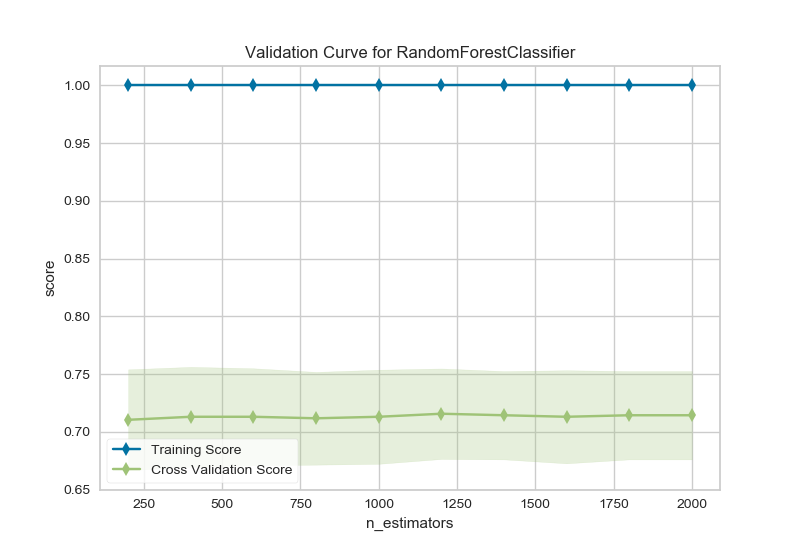

In [218]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    cv = cv, scoring = 'accuracy', n_jobs = -1
)

viz.fit(X_train_Dropped, y_train_Dropped)
viz.poof()

<IPython.core.display.Javascript object>


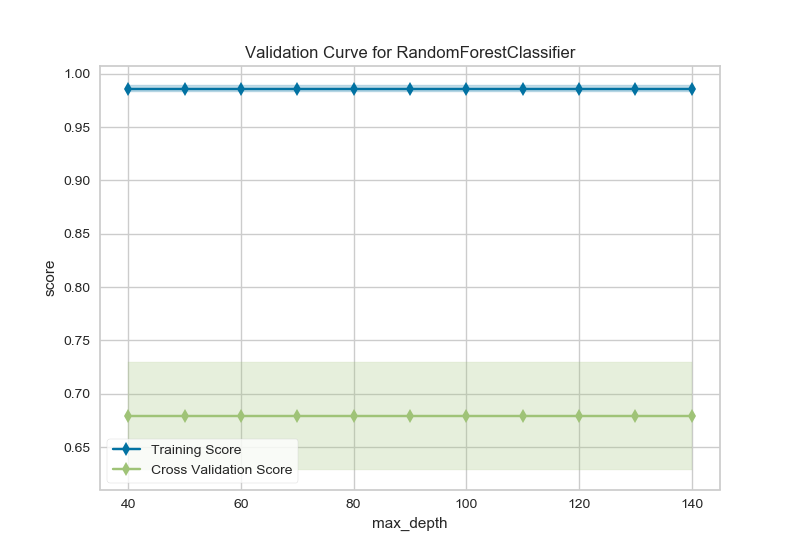

In [220]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(40, 140, num = 11)], 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_Dropped, y_train_Dropped)
viz.poof()

<IPython.core.display.Javascript object>


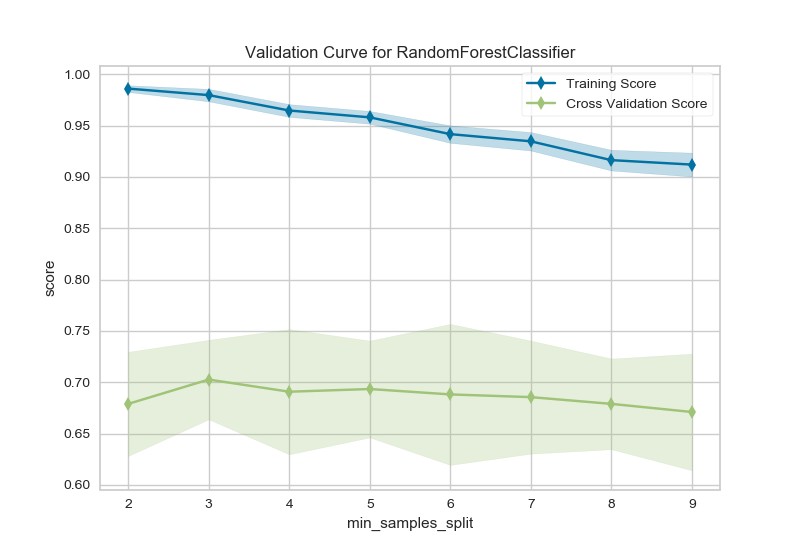

In [222]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_Dropped, y_train_Dropped)
viz.poof()

<IPython.core.display.Javascript object>


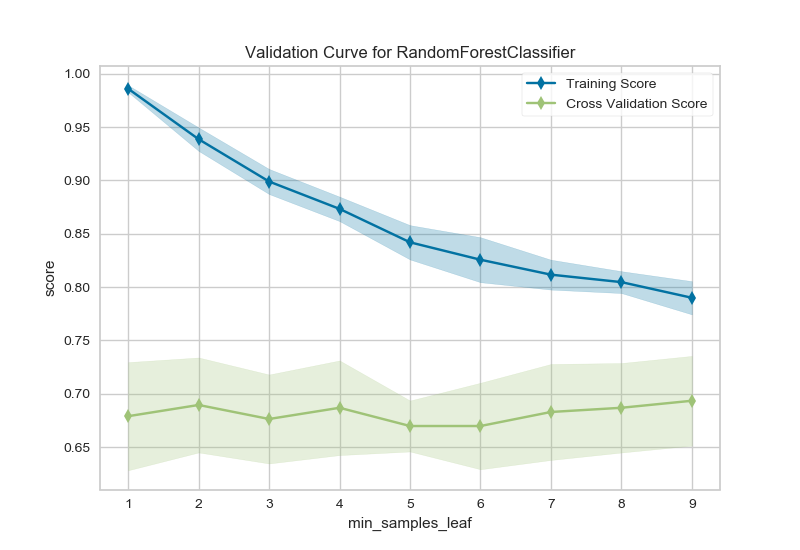

In [224]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_Dropped, y_train_Dropped)
viz.poof()

### Extreme dfExtreme[featCols]

<IPython.core.display.Javascript object>


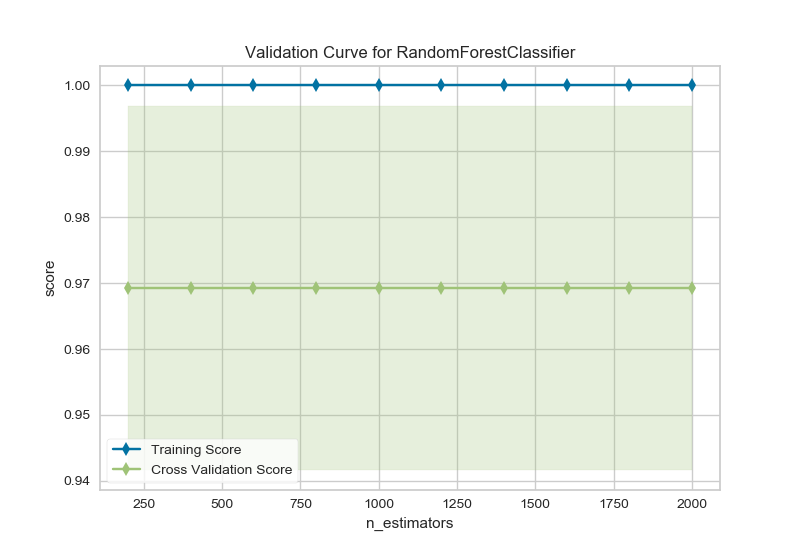

In [219]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    cv = cv, scoring = 'accuracy', n_jobs = -1
)

viz.fit(X_train_extreme, y_train_extreme)
viz.poof()

<IPython.core.display.Javascript object>


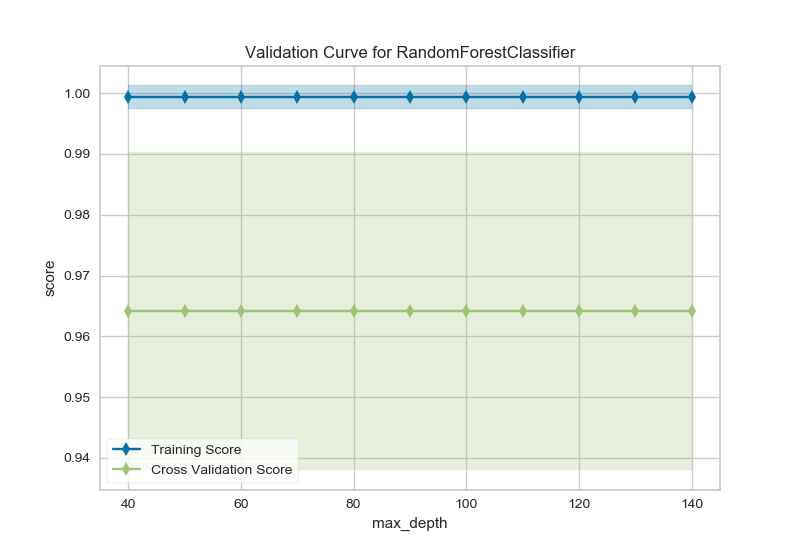

In [221]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(40, 140, num = 11)], 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_extreme, y_train_extreme)
viz.poof()

<IPython.core.display.Javascript object>


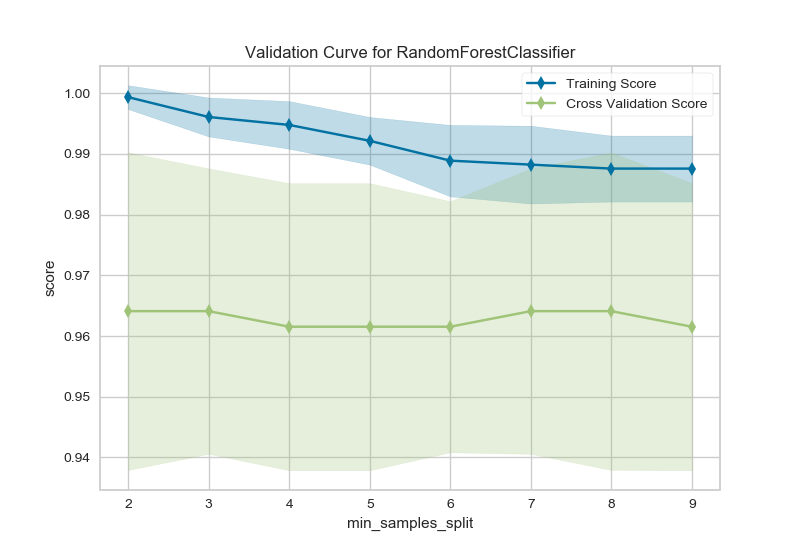

In [225]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_extreme, y_train_extreme)
viz.poof()

### Extremes dfExtreme[featCols] + Best Result Cluster Labels

<IPython.core.display.Javascript object>


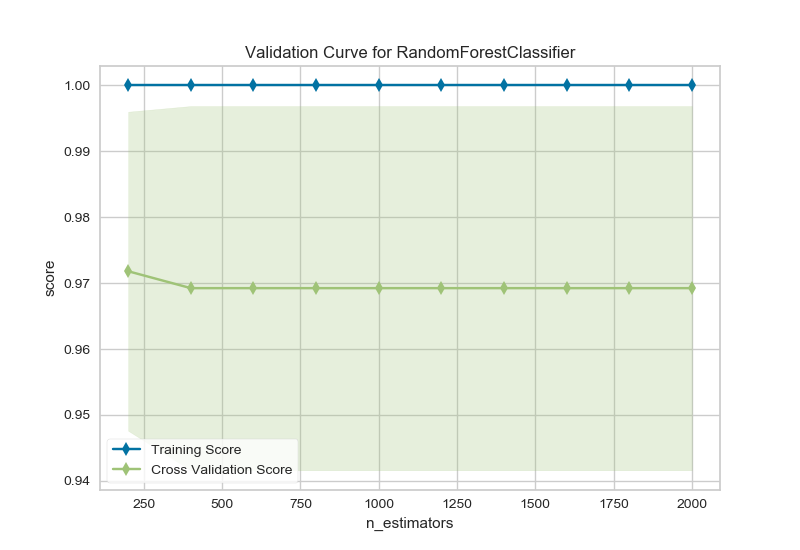

In [252]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    cv = cv, scoring = 'accuracy', n_jobs = -1
)

viz.fit(X_train_cluster, y_train_cluster)
viz.poof()

<IPython.core.display.Javascript object>


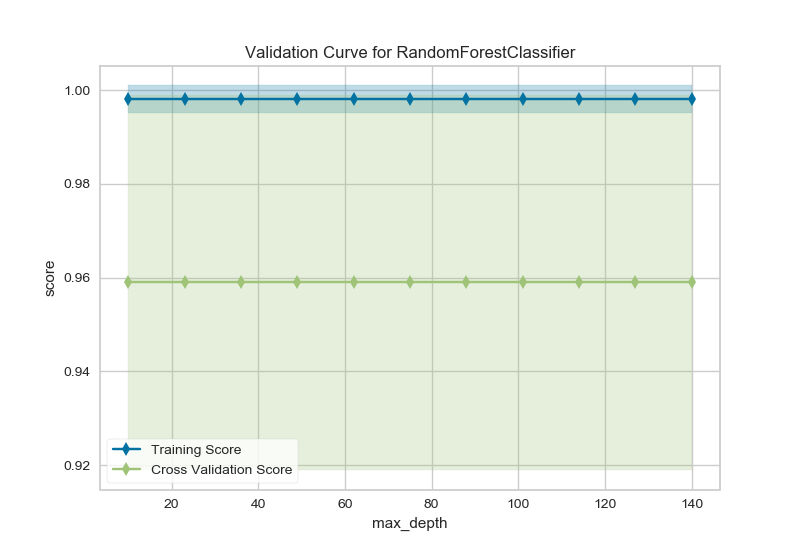

In [253]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(40, 140, num = 11)], 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_cluster, y_train_cluster)
viz.poof()

<IPython.core.display.Javascript object>


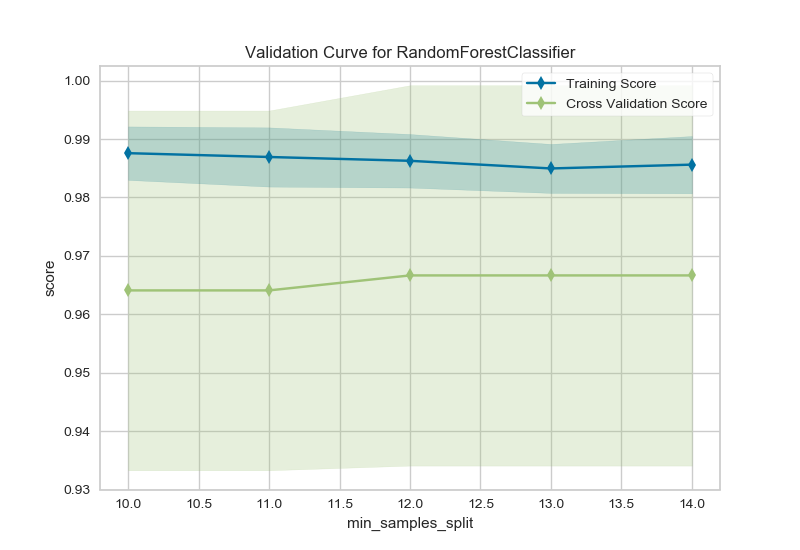

In [256]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_cluster, y_train_cluster)
viz.poof()

<IPython.core.display.Javascript object>


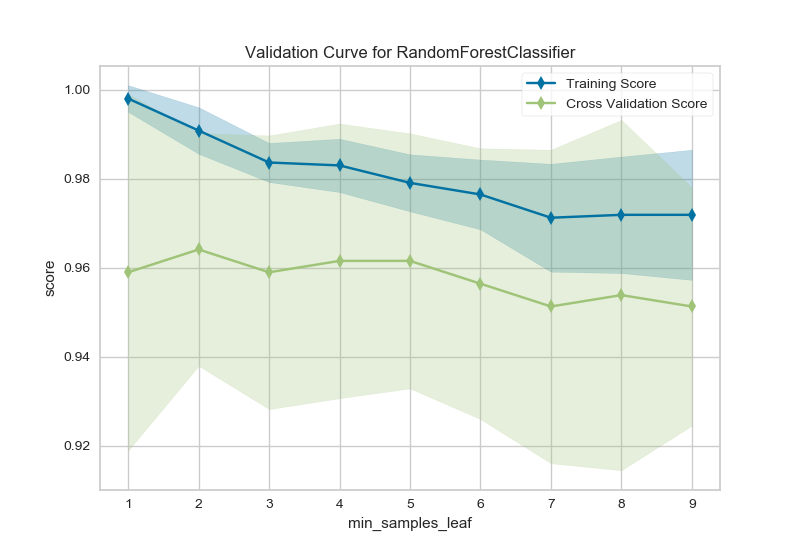

In [250]:
######################
# chose accuracy, not sure if that's correct though
######################

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_cluster, y_train_cluster)
viz.poof()

<a href="#top">Back to Top</a> 
<a id="Model2"></a>
### Evaluate and Compare (10 points)

In [257]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'log2', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(70, 140, num = 8)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 12]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### dfDropped

In [228]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state = 24)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_randomCV = RandomizedSearchCV(estimator = rfc, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = cv, verbose = 2, 
                                  random_state = 18, n_jobs = -1, 
                                  scoring = 'accuracy')

# Fit the random search model
rfc_randomCV.fit(X_train_Dropped, y_train_Dropped)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2', 'sqrt'], 'max_depth': [70, 80, 90, 100, 110, 120, 130, 140, None], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=18, refit=True,
 

In [229]:
# examine the best model
print(rfc_randomCV.best_score_)
print(rfc_randomCV.best_params_)
print(rfc_randomCV.best_estimator_)

0.7223684210526315
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


Best parameters set found on development set: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': True}


<IPython.core.display.Javascript object>


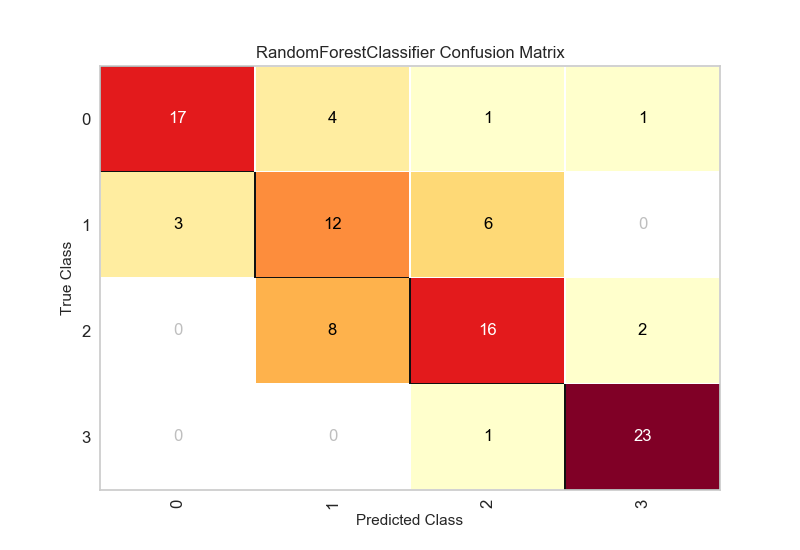

<IPython.core.display.Javascript object>


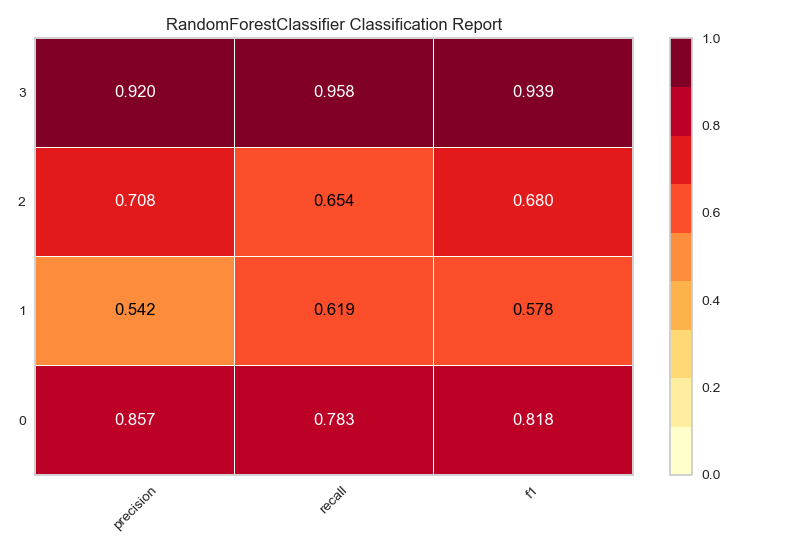

<IPython.core.display.Javascript object>


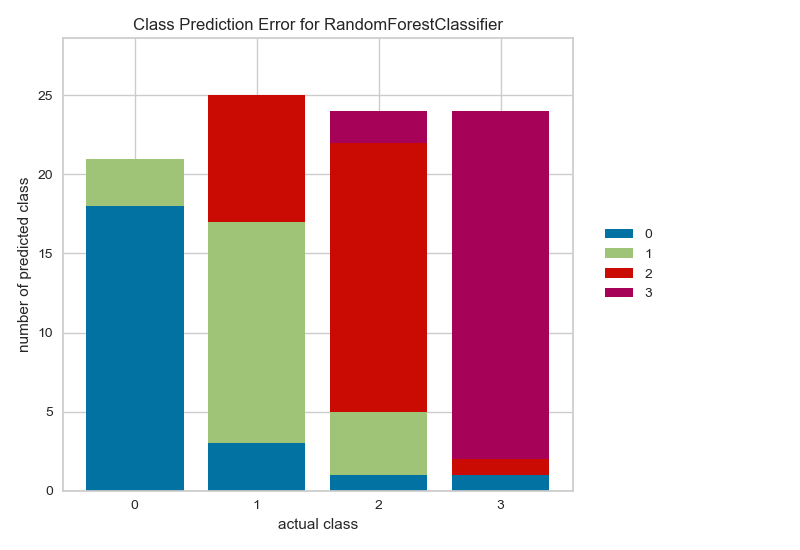

In [230]:
# get best parameters from the gridsearch for the all quartile model
bestValues = rfc_randomCV.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Set model to best values found
cls = RandomForestClassifier(bootstrap = bestValues['bootstrap'], 
                             max_depth = bestValues['max_depth'], 
                             max_features = bestValues['max_features'], 
                             min_samples_leaf = bestValues['min_samples_leaf'], 
                             min_samples_split = bestValues['min_samples_split'], 
                             n_estimators = bestValues['n_estimators'])

classFit = cls.fit(X_train_Dropped, y_train_Dropped)

y_hat = cls.predict(X_test_Dropped)

# Train
cm = ConfusionMatrix(classFit)

# Predict test values
cm.predict(X_test_Dropped)

cm.score(X_test_Dropped, y_test_Dropped)

cm.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Classification Report
vis = ClassificationReport(cls)
vis.fit(X_train_Dropped, y_train_Dropped)
vis.score(X_test_Dropped, y_test_Dropped)
vis.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Prediction Error Report
vis = ClassPredictionError(cls)

# Fit the training data to the visualizer
vis.fit(X_train_Dropped, y_train_Dropped)

# Evaluate the model on the test data
vis.score(X_test_Dropped, y_test_Dropped)

# Draw visualization
vis.poof()

<IPython.core.display.Javascript object>


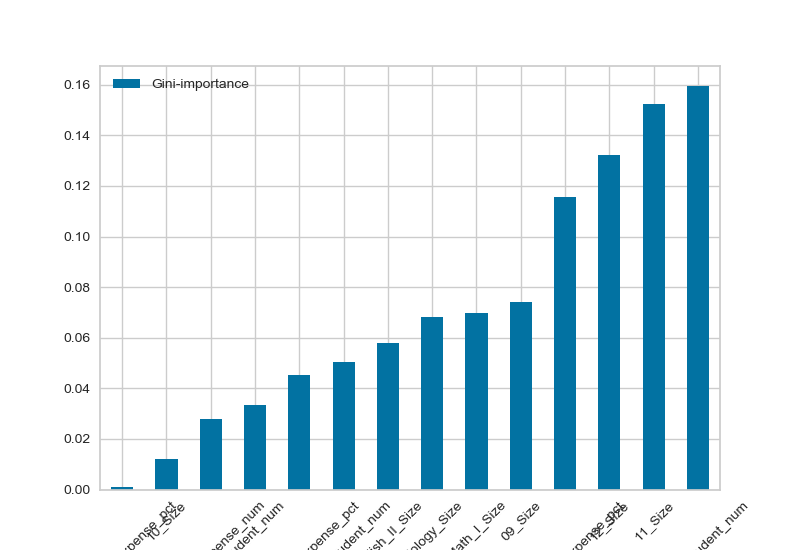

In [231]:
#feature importance of all quartile classification model

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

clf.fit(X_Dropped, y_Dropped)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(dfDropped.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

### dfExtreme

In [232]:
X_extreme = dfExtremes[featCols]
y_extreme = dfExtremes['ACT_Score_Quartiles']

X_train_extreme, X_test_extreme, y_train_extreme, y_test_extreme = train_test_split(X_extreme, y_extreme, random_state=42, test_size=.2)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state = 24)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_randomCV2 = RandomizedSearchCV(estimator = rfc, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = cv, verbose = 2, 
                                  random_state = 18, n_jobs = -1, 
                                  scoring = 'accuracy')

# Fit the random search model
rfc_randomCV2.fit(X_train_extreme, y_train_extreme)

# examine the best model
print(rfc_randomCV2.best_score_)
print(rfc_randomCV2.best_params_)
print(rfc_randomCV2.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.5min finished


0.9692307692307692
{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80, 'bootstrap': False}
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


In [233]:
# examine the best model
print(rfc_randomCV2.best_score_)
print(rfc_randomCV2.best_params_)
print(rfc_randomCV2.best_estimator_)

0.9692307692307692
{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80, 'bootstrap': False}
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


Best parameters set found on development set: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80, 'bootstrap': False}


<IPython.core.display.Javascript object>


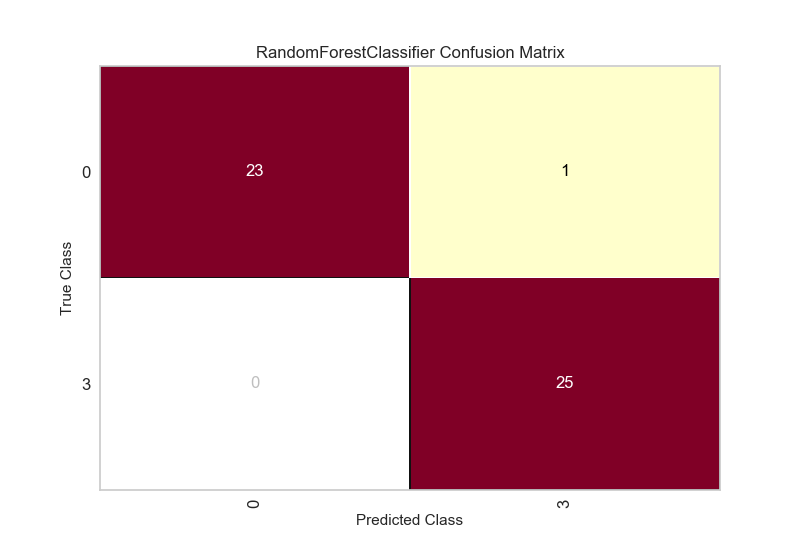

<IPython.core.display.Javascript object>


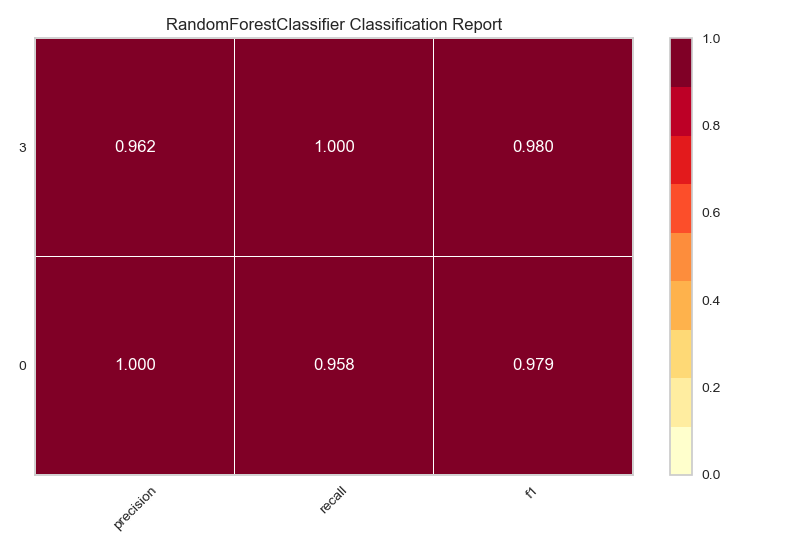

<IPython.core.display.Javascript object>


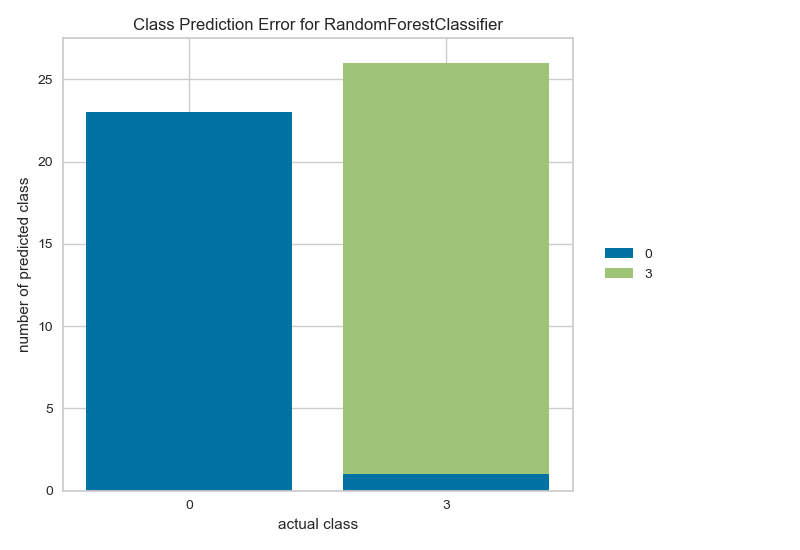

In [234]:
# get best parameters from the gridsearch for the all quartile model
bestValues = rfc_randomCV2.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Set model to best values found
cls = RandomForestClassifier(bootstrap = bestValues['bootstrap'], 
                             max_depth = bestValues['max_depth'], 
                             max_features = bestValues['max_features'], 
                             min_samples_leaf = bestValues['min_samples_leaf'], 
                             min_samples_split = bestValues['min_samples_split'], 
                             n_estimators = bestValues['n_estimators'])

classFit = cls.fit(X_train_extreme, y_train_extreme)

y_hat = cls.predict(X_test_extreme)

# Train
cm = ConfusionMatrix(classFit)

# Predict test values
cm.predict(X_test_extreme)

cm.score(X_test_extreme, y_test_extreme)

cm.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Classification Report
vis = ClassificationReport(cls)
vis.fit(X_train_extreme, y_train_extreme)
vis.score(X_test_extreme, y_test_extreme)
vis.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Prediction Error Report
vis = ClassPredictionError(cls)

# Fit the training data to the visualizer
vis.fit(X_train_extreme, y_train_extreme)

# Evaluate the model on the test data
vis.score(X_test_extreme, y_test_extreme)

# Draw visualization
vis.poof()

<IPython.core.display.Javascript object>


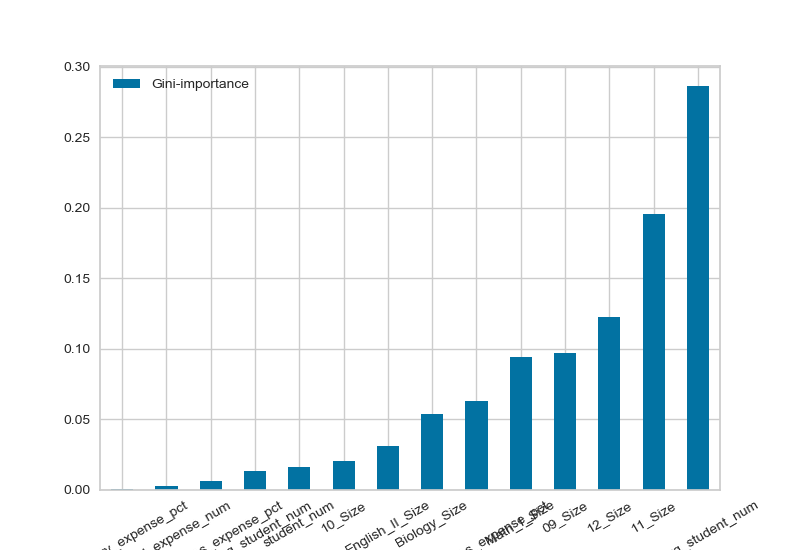

In [239]:
#feature importance of all quartile classification model

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

clf.fit(X_extreme, y_extreme)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(dfExtremes.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=30)

### dfCluster

In [241]:
# This includes dfDropped[featCols] + clustering labels
X_Cluster = dfCluster

# Just look at the Q1 and Q4 data
y_Cluster = dfExtremes['ACT_Score_Quartiles']

X_train_Cluster, X_test_Cluster, y_train_Cluster, y_test_Cluster = train_test_split(X_Cluster, y_Cluster, random_state=42, test_size=.2)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state = 24)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_randomCV3 = RandomizedSearchCV(estimator = rfc, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = cv, verbose = 2, 
                                  random_state = 18, n_jobs = -1, 
                                  scoring = 'accuracy')

# Fit the random search model
rfc_randomCV3.fit(X_train_Cluster, y_train_Cluster)

# examine the best model
print(rfc_randomCV3.best_score_)
print(rfc_randomCV3.best_params_)
print(rfc_randomCV3.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   57.2s


0.9769230769230769
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 80, 'bootstrap': False}
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.5min finished


In [242]:
# Create the parameter grid based on the results of random search
# based on the cluster extreme model
param_grid = {
    'bootstrap': [False],
    'max_depth': [135, 140, 145],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3],
    'n_estimators': [725, 750, 775, 800, 825, 850, 875]
}

# Create a based model
rfc = RandomForestClassifier(random_state = 24)

# Instantiate the grid search model
rfc_gridCV3 = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                                cv = cv, n_jobs = -1, verbose = 2, 
                                scoring = 'accuracy')

# Fit the grid search to the data
rfc_gridCV3.fit(X_train_Cluster, y_train_Cluster)

# examine the best model
print(rfc_gridCV3.best_score_)
print(rfc_gridCV3.best_params_)
print(rfc_gridCV3.best_estimator_)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   29.1s finished


0.9743589743589743
{'bootstrap': False, 'max_depth': 135, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 725}
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=135, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=725, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


Best parameters set found on development set: {'bootstrap': False, 'max_depth': 135, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 725}


<IPython.core.display.Javascript object>


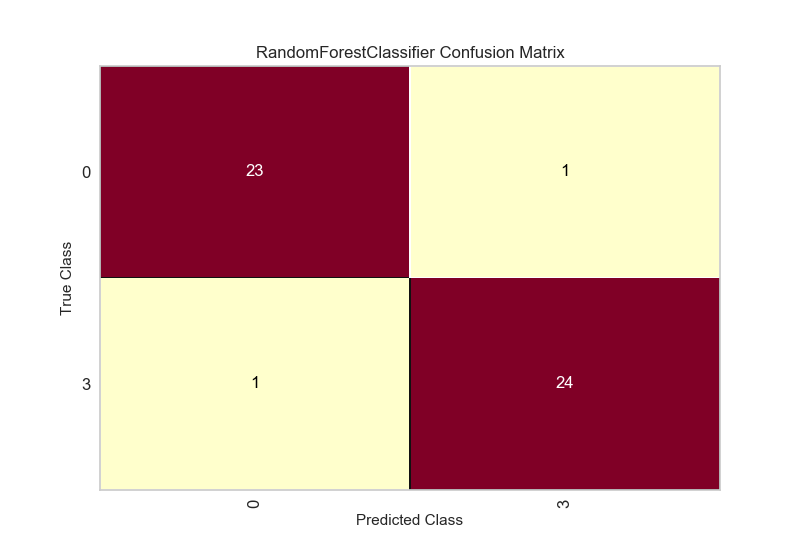

<IPython.core.display.Javascript object>


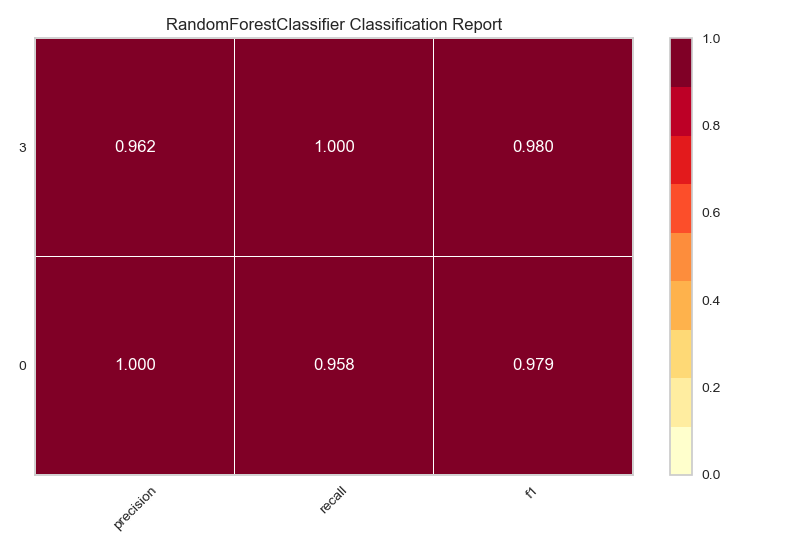

<IPython.core.display.Javascript object>


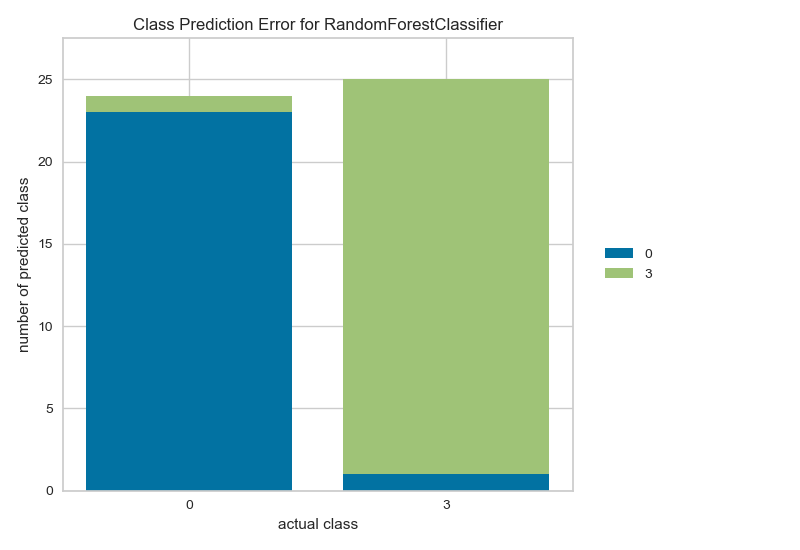

In [243]:
# get best parameters from the gridsearch for the clustered model of Q1 vs Q4
bestValues = rfc_gridCV3.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Set model to best values found
cls = RandomForestClassifier(bootstrap = bestValues['bootstrap'], 
                             max_depth = bestValues['max_depth'], 
                             max_features = bestValues['max_features'], 
                             min_samples_leaf = bestValues['min_samples_leaf'], 
                             min_samples_split = bestValues['min_samples_split'], 
                             n_estimators = bestValues['n_estimators'])

classFit = cls.fit(X_train_Cluster, y_train_Cluster)

y_hat = cls.predict(X_test_Cluster)

# Train
cm = ConfusionMatrix(classFit)

# Predict test values
cm.predict(X_test_Cluster)

cm.score(X_test_Cluster, y_test_Cluster)

cm.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Classification Report
vis = ClassificationReport(cls)
vis.fit(X_train_Cluster, y_train_Cluster)
vis.score(X_test_Cluster, y_test_Cluster)
vis.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Prediction Error Report
vis = ClassPredictionError(cls)

# Fit the training data to the visualizer
vis.fit(X_train_Cluster, y_train_Cluster)

# Evaluate the model on the test data
vis.score(X_test_Cluster, y_test_Cluster)

# Draw visualization
vis.poof()

<IPython.core.display.Javascript object>


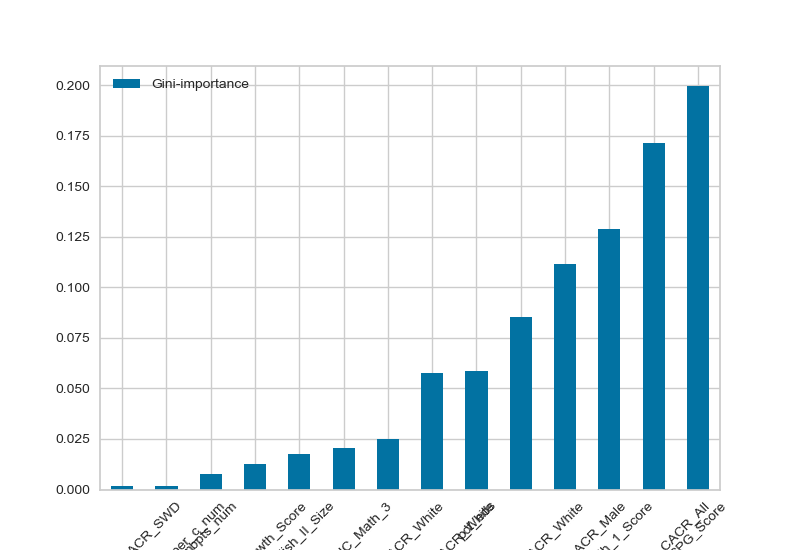

In [244]:
#feature analysis of clustered RF model

clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=135, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

clf.fit(X_Cluster, y_Cluster)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(dfExtremes[featCols].columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

<a href="#top">Back to Top</a> 
<a id="Model3"></a>
### Visualize Results (10 points)

In [113]:
model = MiniBatchKMeans(n_clusters = 4, random_state = 42)
model.fit(dfExtremes[featCols])
cLabels = model.labels_

dfCluster = dfExtremes[featCols].join(pd.get_dummies(cLabels))

X_cluster = dfCluster

y_cluster = dfExtremes['ACT_Score_Quartiles']

dfCluster.drop(dfCluster.columns[[-1,-2,-3,-4]], axis = 1, inplace = True)

<IPython.core.display.Javascript object>


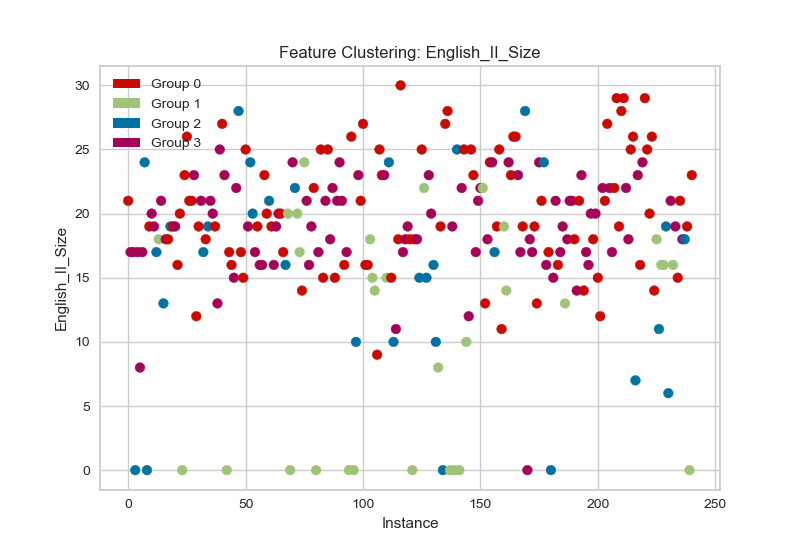

<IPython.core.display.Javascript object>


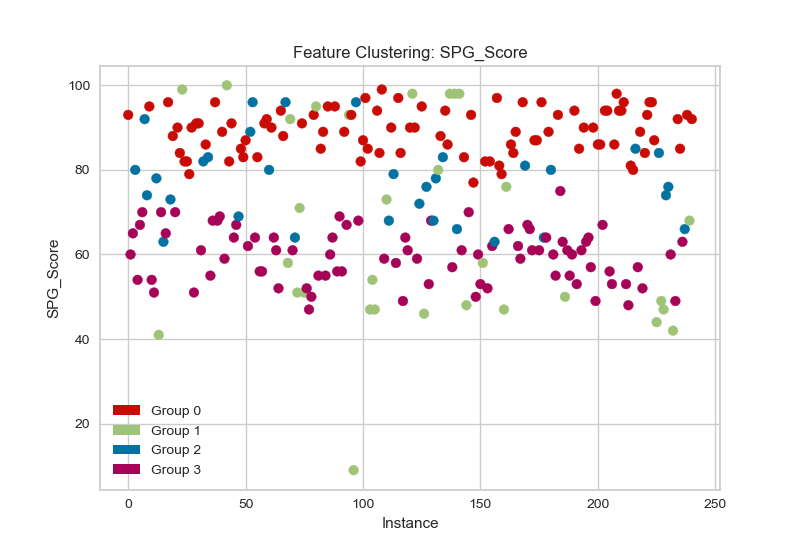

<IPython.core.display.Javascript object>


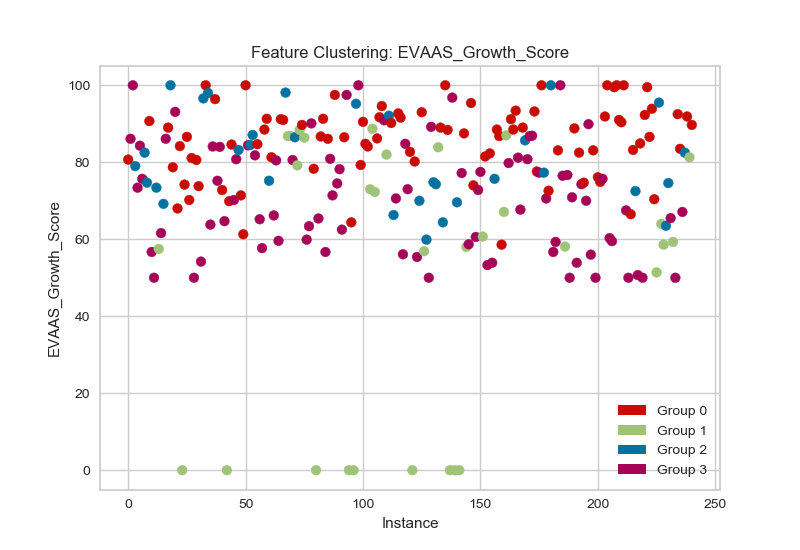

<IPython.core.display.Javascript object>


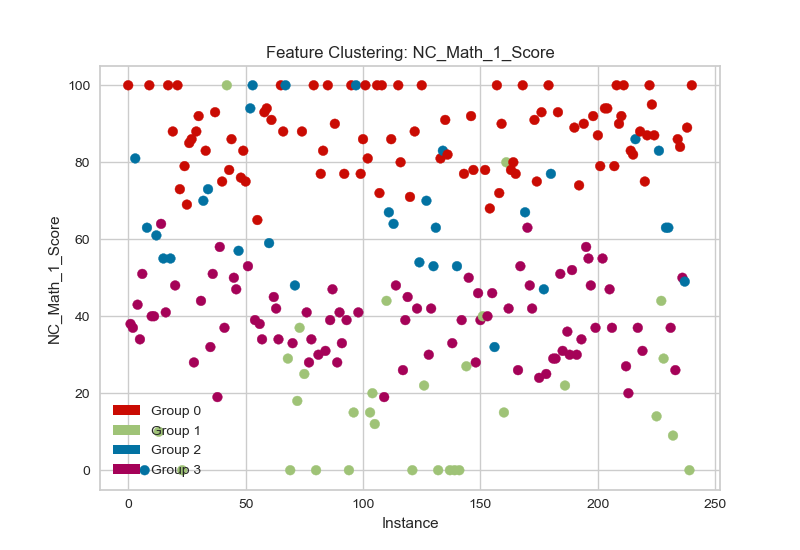

<IPython.core.display.Javascript object>


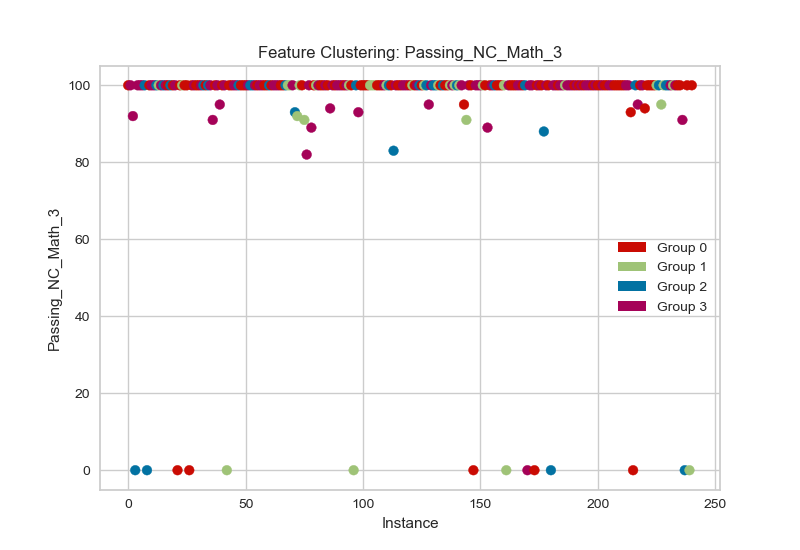

<IPython.core.display.Javascript object>


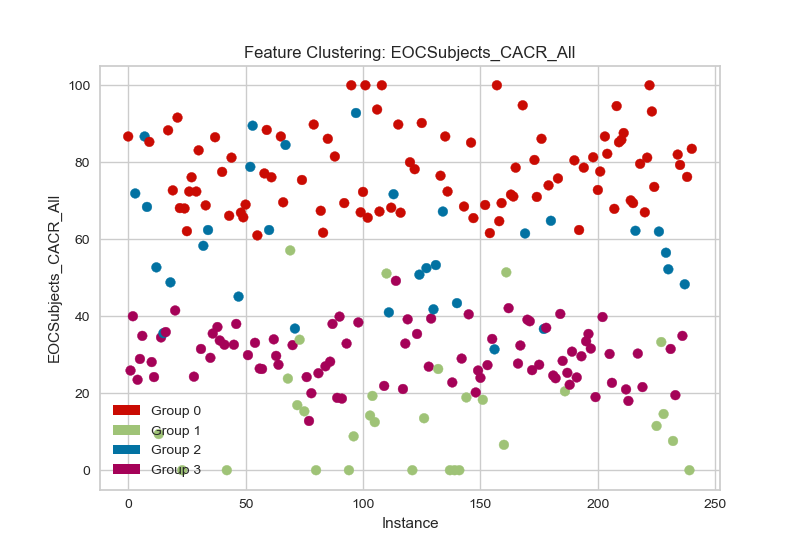

<IPython.core.display.Javascript object>


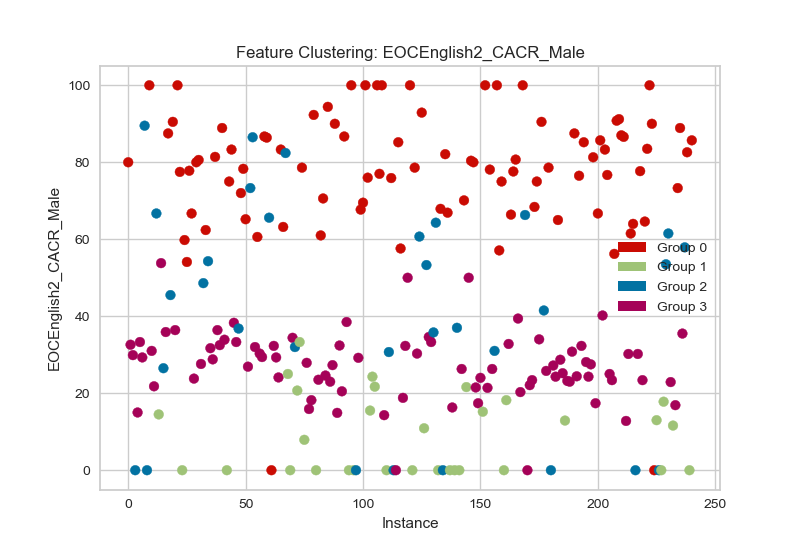

<IPython.core.display.Javascript object>


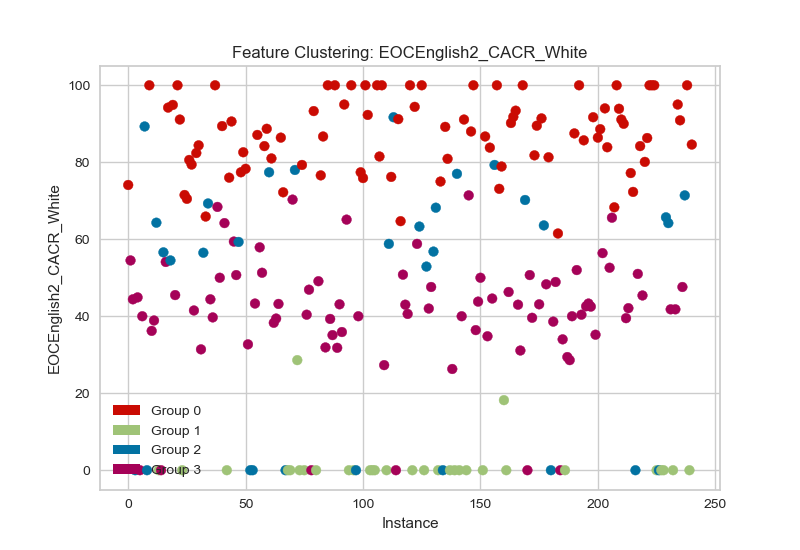

<IPython.core.display.Javascript object>


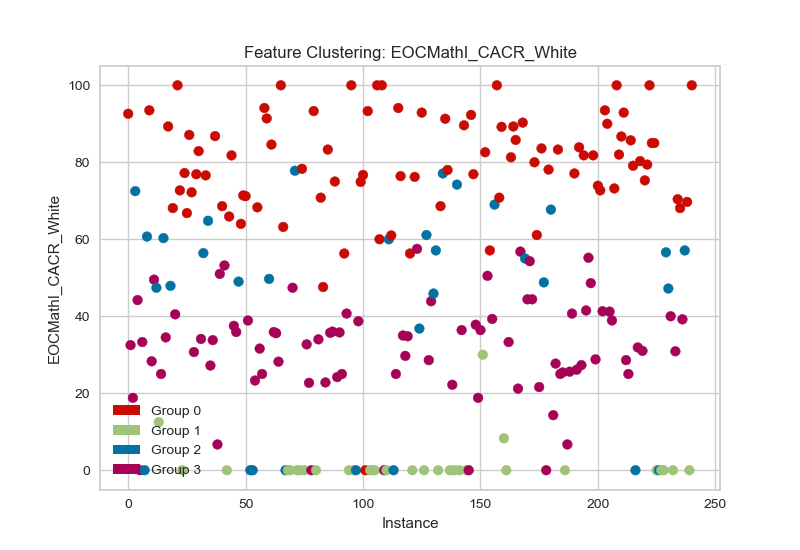

<IPython.core.display.Javascript object>


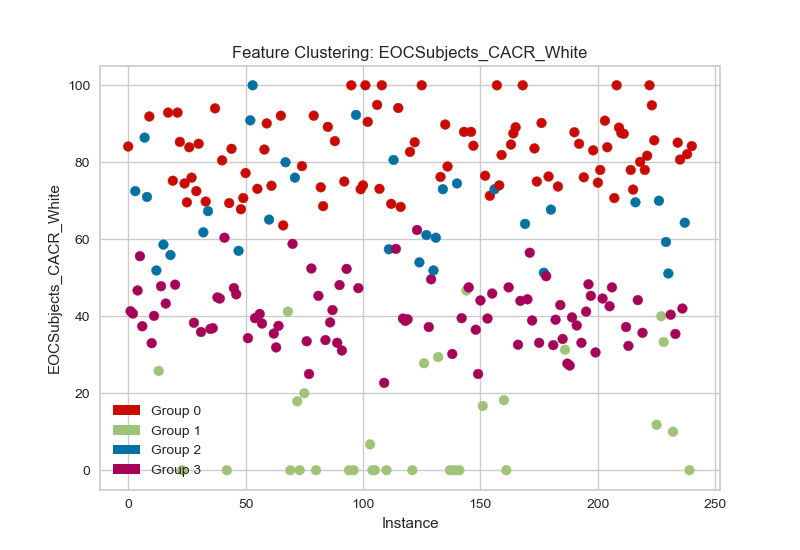

<IPython.core.display.Javascript object>


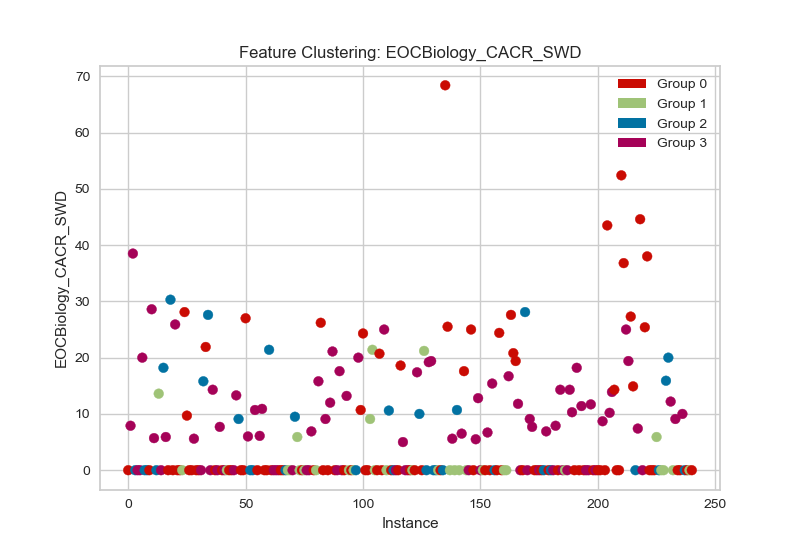

<IPython.core.display.Javascript object>


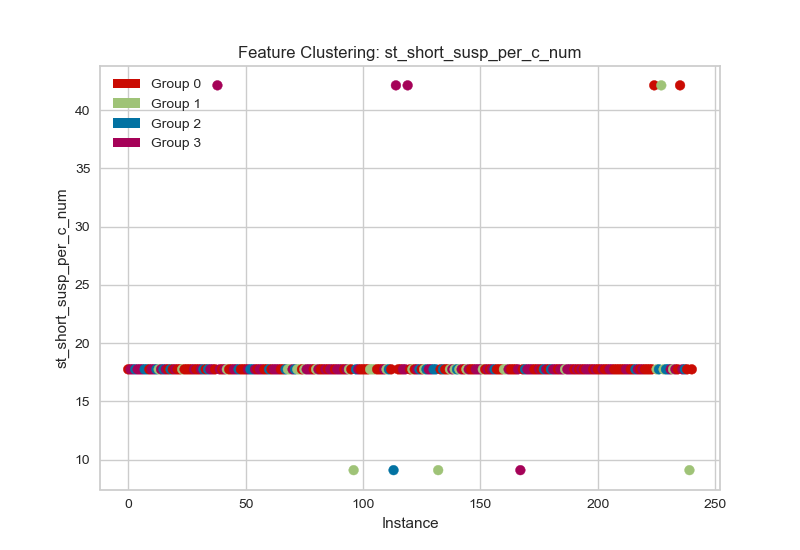

<IPython.core.display.Javascript object>


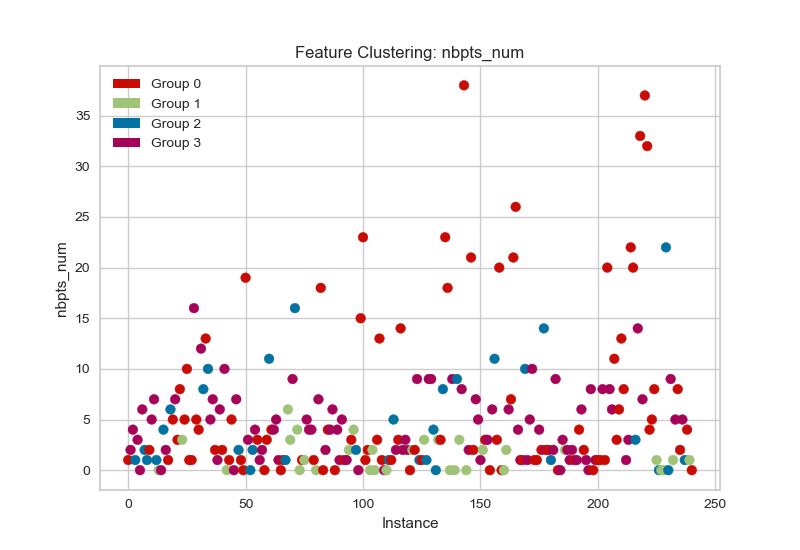

<IPython.core.display.Javascript object>


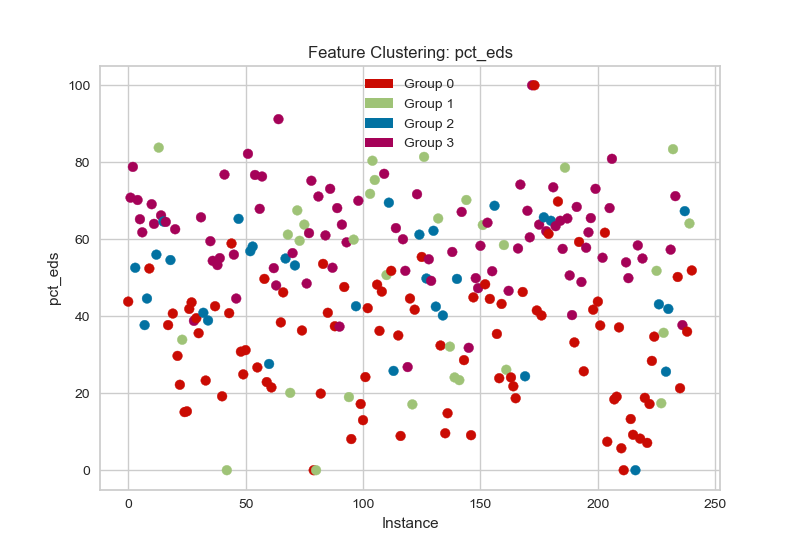

In [129]:
# Credit: https://stackoverflow.com/questions/26558816/matplotlib-scatter-plot-with-legend/26559256
# Credit: https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale
import matplotlib.patches as mpatches
import matplotlib.colors

classes = ['Group 0', 'Group 1', 'Group 2', 'Group 3']
class_colors = ['r', 'g', 'b', 'm']
recs = []
for i in range(0, len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["r","g","b","m"])

for col in dfCluster:
    plt.figure()
    plt.scatter(dataRows, dfCluster[col], c=cLabels, cmap=cmap)
    plt.title("Feature Clustering: {}".format(col))
    plt.xlabel("Instance")
    plt.ylabel(col)
    plt.legend(recs, classes)

<a href="#top">Back to Top</a> 
<a id="Model4"></a>
### Summarize the Ramifications (20 points)

<a href="#top">Back to Top</a> 
<a id="Deployment"></a>
## Deployment

<span style="color: blue">Be critical of your performance and tell the reader how *your* current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

<ul style="color: blue">
<li>How useful is your model for interested parties (i.e., the companies of organizations that might want to use it)?</li>
<li>How would *you* deploy your model for interested parties?</li>
<li>What other data should be collected</li>
<li>How often would the model need to be updated, etc. ?</li>

<a href="#top">Back to Top</a> 
<a id="Exceptional"></a>
## Exceptional Work (10 points total)

<span style="color: blue">You have free reign to provide additional analyses or combine analyses.